##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) and [predicting fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression) — we saw that the accuracy of our model on the validation data would peak after training for a number of epochs, and would then stagnate or start decreasing.

In other words, our model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what we really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.8.0-rc1


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-r1lncnqx
  Running command git clone --filter=blob:none -q https://github.com/tensorflow/docs /tmp/pip-req-build-r1lncnqx


  Resolved https://github.com/tensorflow/docs to commit 83f5d3c231abc6b2f1a2eb069ca0cf61f7598bb4


  Preparing metadata (setup.py) ... - done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=169681 sha256=57cd4bd36a7e1370aa02622e7b9f58dd693030c8bbaf6b679bdcd01c05ca31ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-mg1tjerf/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11&#x202F;000&#x202F;000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

     16384/2816407858 [..............................] - ETA: 6:23:00

     49152/2816407858 [..............................] - ETA: 4:19:05

     90112/2816407858 [..............................] - ETA: 3:29:41

    196608/2816407858 [..............................] - ETA: 2:06:46

    401408/2816407858 [..............................] - ETA: 1:17:06

    811008/2816407858 [..............................] - ETA: 45:35  

   1630208/2816407858 [..............................] - ETA: 26:22

   3252224/2816407858 [..............................] - ETA: 15:03

   6389760/2816407858 [..............................] - ETA: 8:35 

   9535488/2816407858 [..............................] - ETA: 6:23

  12673024/2816407858 [..............................] - ETA: 5:16

  15802368/2816407858 [..............................] - ETA: 4:36

  18915328/2816407858 [..............................] - ETA: 4:02

  18948096/2816407858 [..............................] - ETA: 4:09

  22036480/2816407858 [..............................] - ETA: 3:44

  22061056/2816407858 [..............................] - ETA: 3:50

  25116672/2816407858 [..............................] - ETA: 3:36

  28254208/2816407858 [..............................] - ETA: 3:25

  31367168/2816407858 [..............................] - ETA: 3:16

  34283520/2816407858 [..............................] - ETA: 3:09

  37429248/2816407858 [..............................] - ETA: 3:03

  40542208/2816407858 [..............................] - ETA: 2:57

  43614208/2816407858 [..............................] - ETA: 2:53

  46694400/2816407858 [..............................] - ETA: 2:46

  47349760/2816407858 [..............................] - ETA: 2:47

  49840128/2816407858 [..............................] - ETA: 2:45

  52928512/2816407858 [..............................] - ETA: 2:38

  52936704/2816407858 [..............................] - ETA: 2:42

  55853056/2816407858 [..............................] - ETA: 2:40

  58949632/2816407858 [..............................] - ETA: 2:37

  62046208/2816407858 [..............................] - ETA: 2:35

  64913408/2816407858 [..............................] - ETA: 2:30

  65142784/2816407858 [..............................] - ETA: 2:33

  67796992/2816407858 [..............................] - ETA: 2:29

  68247552/2816407858 [..............................] - ETA: 2:31

  70893568/2816407858 [..............................] - ETA: 2:27

  71344128/2816407858 [..............................] - ETA: 2:29

  74260480/2816407858 [..............................] - ETA: 2:25

  74457088/2816407858 [..............................] - ETA: 2:27

  77332480/2816407858 [..............................] - ETA: 2:24

  77553664/2816407858 [..............................] - ETA: 2:26

  80060416/2816407858 [..............................] - ETA: 2:23

  80666624/2816407858 [..............................] - ETA: 2:24

  83165184/2816407858 [..............................] - ETA: 2:22

  83591168/2816407858 [..............................] - ETA: 2:24

  86286336/2816407858 [..............................] - ETA: 2:20

  86720512/2816407858 [..............................] - ETA: 2:22

  89063424/2816407858 [..............................] - ETA: 2:20

  89817088/2816407858 [..............................] - ETA: 2:21

  92151808/2816407858 [..............................] - ETA: 2:19

  92930048/2816407858 [..............................] - ETA: 2:20

  95207424/2816407858 [>.............................] - ETA: 2:18

  96043008/2816407858 [>.............................] - ETA: 2:19

  98459648/2816407858 [>.............................] - ETA: 2:17

  99147776/2816407858 [>.............................] - ETA: 2:18

 101228544/2816407858 [>.............................] - ETA: 2:16

 102244352/2816407858 [>.............................] - ETA: 2:17

 104357888/2816407858 [>.............................] - ETA: 2:15

 105332736/2816407858 [>.............................] - ETA: 2:16

 106668032/2816407858 [>.............................] - ETA: 2:16

 108421120/2816407858 [>.............................] - ETA: 2:15

 109445120/2816407858 [>.............................] - ETA: 2:15

 111534080/2816407858 [>.............................] - ETA: 2:14

 112541696/2816407858 [>.............................] - ETA: 2:14

 114630656/2816407858 [>.............................] - ETA: 2:13

 115638272/2816407858 [>.............................] - ETA: 2:13

 117760000/2816407858 [>.............................] - ETA: 2:12

 118431744/2816407858 [>.............................] - ETA: 2:13

 120840192/2816407858 [>.............................] - ETA: 2:12

 121487360/2816407858 [>.............................] - ETA: 2:12

 123813888/2816407858 [>.............................] - ETA: 2:11

 123985920/2816407858 [>.............................] - ETA: 2:12

 124985344/2816407858 [>.............................] - ETA: 2:12

 127066112/2816407858 [>.............................] - ETA: 2:11

 128114688/2816407858 [>.............................] - ETA: 2:11

 130138112/2816407858 [>.............................] - ETA: 2:10

 131227648/2816407858 [>.............................] - ETA: 2:10

 133267456/2816407858 [>.............................] - ETA: 2:10

 134242304/2816407858 [>.............................] - ETA: 2:10

 136396800/2816407858 [>.............................] - ETA: 2:09

 137371648/2816407858 [>.............................] - ETA: 2:09

 139526144/2816407858 [>.............................] - ETA: 2:09

 141484032/2816407858 [>.............................] - ETA: 2:08

 142655488/2816407858 [>.............................] - ETA: 2:08

 144580608/2816407858 [>.............................] - ETA: 2:07

 145776640/2816407858 [>.............................] - ETA: 2:08

 147447808/2816407858 [>.............................] - ETA: 2:07

 148889600/2816407858 [>.............................] - ETA: 2:07

 150528000/2816407858 [>.............................] - ETA: 2:07

 151969792/2816407858 [>.............................] - ETA: 2:07

 153337856/2816407858 [>.............................] - ETA: 2:06

 154804224/2816407858 [>.............................] - ETA: 2:07

 156614656/2816407858 [>.............................] - ETA: 2:06

 157917184/2816407858 [>.............................] - ETA: 2:06

 159727616/2816407858 [>.............................] - ETA: 2:05

 161030144/2816407858 [>.............................] - ETA: 2:06

 162807808/2816407858 [>.............................] - ETA: 2:05

 164110336/2816407858 [>.............................] - ETA: 2:05

 165806080/2816407858 [>.............................] - ETA: 2:05

 166961152/2816407858 [>.............................] - ETA: 2:05

 168714240/2816407858 [>.............................] - ETA: 2:04

 170033152/2816407858 [>.............................] - ETA: 2:05

 171769856/2816407858 [>.............................] - ETA: 2:04

 173162496/2816407858 [>.............................] - ETA: 2:04

 174866432/2816407858 [>.............................] - ETA: 2:04

 176259072/2816407858 [>.............................] - ETA: 2:04

 177872896/2816407858 [>.............................] - ETA: 2:03

 179372032/2816407858 [>.............................] - ETA: 2:03

 180641792/2816407858 [>.............................] - ETA: 2:03

 182140928/2816407858 [>.............................] - ETA: 2:03

 183582720/2816407858 [>.............................] - ETA: 2:03

 185221120/2816407858 [>.............................] - ETA: 2:03

 186712064/2816407858 [>.............................] - ETA: 2:02

 188317696/2816407858 [=>............................] - ETA: 2:02

 189808640/2816407858 [=>............................] - ETA: 2:02

 191447040/2816407858 [=>............................] - ETA: 2:02

 192806912/2816407858 [=>............................] - ETA: 2:02

 194568192/2816407858 [=>............................] - ETA: 2:02

 195551232/2816407858 [=>............................] - ETA: 2:02

 197697536/2816407858 [=>............................] - ETA: 2:01

 198672384/2816407858 [=>............................] - ETA: 2:01

 200810496/2816407858 [=>............................] - ETA: 2:01

 201744384/2816407858 [=>............................] - ETA: 2:01

 203890688/2816407858 [=>............................] - ETA: 2:01

 204832768/2816407858 [=>............................] - ETA: 2:01

 206995456/2816407858 [=>............................] - ETA: 2:00

 207650816/2816407858 [=>............................] - ETA: 2:00

 210124800/2816407858 [=>............................] - ETA: 2:00

 210640896/2816407858 [=>............................] - ETA: 2:00

 213221376/2816407858 [=>............................] - ETA: 2:00

 213409792/2816407858 [=>............................] - ETA: 2:01

 216555520/2816407858 [=>............................] - ETA: 2:01

 218243072/2816407858 [=>............................] - ETA: 2:01

 221347840/2816407858 [=>............................] - ETA: 2:00

 221388800/2816407858 [=>............................] - ETA: 2:01

 224460800/2816407858 [=>............................] - ETA: 2:01

 227590144/2816407858 [=>............................] - ETA: 2:00

 230711296/2816407858 [=>............................] - ETA: 2:00

 233840640/2816407858 [=>............................] - ETA: 2:00

 236904448/2816407858 [=>............................] - ETA: 1:59

 240033792/2816407858 [=>............................] - ETA: 1:58

 240050176/2816407858 [=>............................] - ETA: 1:59

 243154944/2816407858 [=>............................] - ETA: 1:59

 246267904/2816407858 [=>............................] - ETA: 1:58

 246300672/2816407858 [=>............................] - ETA: 1:58

 249380864/2816407858 [=>............................] - ETA: 1:58

 249413632/2816407858 [=>............................] - ETA: 1:58

 252461056/2816407858 [=>............................] - ETA: 1:57

 252526592/2816407858 [=>............................] - ETA: 1:58

 255565824/2816407858 [=>............................] - ETA: 1:57

 255614976/2816407858 [=>............................] - ETA: 1:58

 258433024/2816407858 [=>............................] - ETA: 1:57

 261513216/2816407858 [=>............................] - ETA: 1:57

 264495104/2816407858 [=>............................] - ETA: 1:57

 267567104/2816407858 [=>............................] - ETA: 1:57

 270696448/2816407858 [=>............................] - ETA: 1:56

 273596416/2816407858 [=>............................] - ETA: 1:56

 276692992/2816407858 [=>............................] - ETA: 1:55

 276742144/2816407858 [=>............................] - ETA: 1:56

 279764992/2816407858 [=>............................] - ETA: 1:55

 279855104/2816407858 [=>............................] - ETA: 1:56

 282525696/2816407858 [==>...........................] - ETA: 1:55

 282927104/2816407858 [==>...........................] - ETA: 1:55

 285597696/2816407858 [==>...........................] - ETA: 1:55

 285990912/2816407858 [==>...........................] - ETA: 1:55

 288727040/2816407858 [==>...........................] - ETA: 1:55

 289120256/2816407858 [==>...........................] - ETA: 1:55

 291872768/2816407858 [==>...........................] - ETA: 1:54

 292200448/2816407858 [==>...........................] - ETA: 1:55

 294920192/2816407858 [==>...........................] - ETA: 1:54

 295239680/2816407858 [==>...........................] - ETA: 1:54

 298000384/2816407858 [==>...........................] - ETA: 1:54

 298385408/2816407858 [==>...........................] - ETA: 1:54

 301105152/2816407858 [==>...........................] - ETA: 1:54

 301498368/2816407858 [==>...........................] - ETA: 1:54

 304234496/2816407858 [==>...........................] - ETA: 1:53

 304619520/2816407858 [==>...........................] - ETA: 1:54

 307347456/2816407858 [==>...........................] - ETA: 1:53

 307716096/2816407858 [==>...........................] - ETA: 1:54

 310435840/2816407858 [==>...........................] - ETA: 1:53

 310763520/2816407858 [==>...........................] - ETA: 1:53

 313532416/2816407858 [==>...........................] - ETA: 1:53

 313860096/2816407858 [==>...........................] - ETA: 1:53

 316661760/2816407858 [==>...........................] - ETA: 1:52

 316989440/2816407858 [==>...........................] - ETA: 1:53

 319561728/2816407858 [==>...........................] - ETA: 1:52

 320110592/2816407858 [==>...........................] - ETA: 1:53

 322641920/2816407858 [==>...........................] - ETA: 1:52

 323158016/2816407858 [==>...........................] - ETA: 1:52

 325771264/2816407858 [==>...........................] - ETA: 1:52

 326287360/2816407858 [==>...........................] - ETA: 1:52

 328876032/2816407858 [==>...........................] - ETA: 1:52

 329433088/2816407858 [==>...........................] - ETA: 1:52

 331874304/2816407858 [==>...........................] - ETA: 1:51

 332546048/2816407858 [==>...........................] - ETA: 1:52

 334987264/2816407858 [==>...........................] - ETA: 1:51

 335503360/2816407858 [==>...........................] - ETA: 1:52

 338067456/2816407858 [==>...........................] - ETA: 1:51

 338649088/2816407858 [==>...........................] - ETA: 1:51

 340852736/2816407858 [==>...........................] - ETA: 1:51

 341778432/2816407858 [==>...........................] - ETA: 1:51

 343949312/2816407858 [==>...........................] - ETA: 1:51

 344875008/2816407858 [==>...........................] - ETA: 1:51

 347062272/2816407858 [==>...........................] - ETA: 1:51

 347897856/2816407858 [==>...........................] - ETA: 1:51

 350167040/2816407858 [==>...........................] - ETA: 1:50

 351010816/2816407858 [==>...........................] - ETA: 1:50

 353099776/2816407858 [==>...........................] - ETA: 1:50

 354140160/2816407858 [==>...........................] - ETA: 1:50

 356196352/2816407858 [==>...........................] - ETA: 1:50

 357236736/2816407858 [==>...........................] - ETA: 1:50

 359309312/2816407858 [==>...........................] - ETA: 1:50

 360325120/2816407858 [==>...........................] - ETA: 1:50

 362422272/2816407858 [==>...........................] - ETA: 1:50

 363266048/2816407858 [==>...........................] - ETA: 1:50

 365494272/2816407858 [==>...........................] - ETA: 1:49

 366338048/2816407858 [==>...........................] - ETA: 1:49

 368607232/2816407858 [==>...........................] - ETA: 1:49

 369451008/2816407858 [==>...........................] - ETA: 1:49

 371605504/2816407858 [==>...........................] - ETA: 1:49

 372563968/2816407858 [==>...........................] - ETA: 1:49

 374685696/2816407858 [==>...........................] - ETA: 1:49

 375676928/2816407858 [===>..........................] - ETA: 1:49

 377798656/2816407858 [===>..........................] - ETA: 1:49

 378748928/2816407858 [===>..........................] - ETA: 1:49

 380903424/2816407858 [===>..........................] - ETA: 1:48

 381747200/2816407858 [===>..........................] - ETA: 1:49

 384032768/2816407858 [===>..........................] - ETA: 1:48

 384876544/2816407858 [===>..........................] - ETA: 1:48

 386883584/2816407858 [===>..........................] - ETA: 1:48

 387956736/2816407858 [===>..........................] - ETA: 1:48

 389980160/2816407858 [===>..........................] - ETA: 1:48

 391045120/2816407858 [===>..........................] - ETA: 1:48

 393109504/2816407858 [===>..........................] - ETA: 1:48

 394158080/2816407858 [===>..........................] - ETA: 1:48

 396181504/2816407858 [===>..........................] - ETA: 1:47

 397090816/2816407858 [===>..........................] - ETA: 1:48

 399343616/2816407858 [===>..........................] - ETA: 1:47

 400203776/2816407858 [===>..........................] - ETA: 1:47

 402145280/2816407858 [===>..........................] - ETA: 1:47

 403324928/2816407858 [===>..........................] - ETA: 1:47

 405241856/2816407858 [===>..........................] - ETA: 1:47

 406421504/2816407858 [===>..........................] - ETA: 1:47

 408346624/2816407858 [===>..........................] - ETA: 1:47

 409550848/2816407858 [===>..........................] - ETA: 1:47

 411172864/2816407858 [===>..........................] - ETA: 1:46

 412483584/2816407858 [===>..........................] - ETA: 1:47

 414801920/2816407858 [===>..........................] - ETA: 1:46

 415580160/2816407858 [===>..........................] - ETA: 1:47

 417923072/2816407858 [===>..........................] - ETA: 1:46

 418668544/2816407858 [===>..........................] - ETA: 1:46

 421011456/2816407858 [===>..........................] - ETA: 1:46

 421732352/2816407858 [===>..........................] - ETA: 1:46

 424083456/2816407858 [===>..........................] - ETA: 1:46

 424828928/2816407858 [===>..........................] - ETA: 1:46

 427180032/2816407858 [===>..........................] - ETA: 1:46

 427597824/2816407858 [===>..........................] - ETA: 1:46

 430137344/2816407858 [===>..........................] - ETA: 1:45

 430743552/2816407858 [===>..........................] - ETA: 1:46

 433201152/2816407858 [===>..........................] - ETA: 1:45

 433881088/2816407858 [===>..........................] - ETA: 1:45

 436297728/2816407858 [===>..........................] - ETA: 1:45

 436813824/2816407858 [===>..........................] - ETA: 1:45

 439443456/2816407858 [===>..........................] - ETA: 1:45

 439934976/2816407858 [===>..........................] - ETA: 1:45

 442236928/2816407858 [===>..........................] - ETA: 1:45

 443064320/2816407858 [===>..........................] - ETA: 1:45

 445333504/2816407858 [===>..........................] - ETA: 1:45

 446160896/2816407858 [===>..........................] - ETA: 1:45

 448413696/2816407858 [===>..........................] - ETA: 1:44

 449060864/2816407858 [===>..........................] - ETA: 1:45

 451575808/2816407858 [===>..........................] - ETA: 1:44

 452190208/2816407858 [===>..........................] - ETA: 1:44

 454418432/2816407858 [===>..........................] - ETA: 1:44

 455311360/2816407858 [===>..........................] - ETA: 1:44

 457506816/2816407858 [===>..........................] - ETA: 1:44

 458424320/2816407858 [===>..........................] - ETA: 1:44

 459939840/2816407858 [===>..........................] - ETA: 1:44

 461537280/2816407858 [===>..........................] - ETA: 1:44

 462716928/2816407858 [===>..........................] - ETA: 1:44

 464306176/2816407858 [===>..........................] - ETA: 1:44

 465747968/2816407858 [===>..........................] - ETA: 1:44

 467369984/2816407858 [===>..........................] - ETA: 1:44

 468779008/2816407858 [===>..........................] - ETA: 1:43

 470466560/2816407858 [====>.........................] - ETA: 1:43

 471891968/2816407858 [====>.........................] - ETA: 1:43

 473587712/2816407858 [====>.........................] - ETA: 1:43

 475029504/2816407858 [====>.........................] - ETA: 1:43

 476733440/2816407858 [====>.........................] - ETA: 1:43

 478142464/2816407858 [====>.........................] - ETA: 1:43

 479772672/2816407858 [====>.........................] - ETA: 1:43

 481255424/2816407858 [====>.........................] - ETA: 1:43

 482885632/2816407858 [====>.........................] - ETA: 1:43

 484368384/2816407858 [====>.........................] - ETA: 1:43

 485982208/2816407858 [====>.........................] - ETA: 1:42

 487473152/2816407858 [====>.........................] - ETA: 1:42

 489111552/2816407858 [====>.........................] - ETA: 1:42

 490602496/2816407858 [====>.........................] - ETA: 1:42

 492208128/2816407858 [====>.........................] - ETA: 1:42

 493699072/2816407858 [====>.........................] - ETA: 1:42

 495312896/2816407858 [====>.........................] - ETA: 1:42

 496771072/2816407858 [====>.........................] - ETA: 1:42

 498442240/2816407858 [====>.........................] - ETA: 1:42

 499482624/2816407858 [====>.........................] - ETA: 1:42

 501538816/2816407858 [====>.........................] - ETA: 1:42

 502579200/2816407858 [====>.........................] - ETA: 1:42

 504668160/2816407858 [====>.........................] - ETA: 1:41

 505708544/2816407858 [====>.........................] - ETA: 1:41

 507600896/2816407858 [====>.........................] - ETA: 1:41

 508919808/2816407858 [====>.........................] - ETA: 1:41

 510713856/2816407858 [====>.........................] - ETA: 1:41

 511934464/2816407858 [====>.........................] - ETA: 1:41

 513794048/2816407858 [====>.........................] - ETA: 1:41

 515039232/2816407858 [====>.........................] - ETA: 1:41

 516890624/2816407858 [====>.........................] - ETA: 1:41

 518152192/2816407858 [====>.........................] - ETA: 1:41

 519970816/2816407858 [====>.........................] - ETA: 1:41

 521265152/2816407858 [====>.........................] - ETA: 1:41

 523100160/2816407858 [====>.........................] - ETA: 1:40

 524345344/2816407858 [====>.........................] - ETA: 1:40

 526229504/2816407858 [====>.........................] - ETA: 1:40

 527261696/2816407858 [====>.........................] - ETA: 1:40

 529301504/2816407858 [====>.........................] - ETA: 1:40

 530341888/2816407858 [====>.........................] - ETA: 1:40

 532234240/2816407858 [====>.........................] - ETA: 1:40

 533479424/2816407858 [====>.........................] - ETA: 1:40

 535347200/2816407858 [====>.........................] - ETA: 1:40

 536576000/2816407858 [====>.........................] - ETA: 1:40

 538476544/2816407858 [====>.........................] - ETA: 1:40

 539656192/2816407858 [====>.........................] - ETA: 1:40

 541556736/2816407858 [====>.........................] - ETA: 1:39

 542801920/2816407858 [====>.........................] - ETA: 1:39

 544677888/2816407858 [====>.........................] - ETA: 1:39

 545931264/2816407858 [====>.........................] - ETA: 1:39

 547807232/2816407858 [====>.........................] - ETA: 1:39

 548839424/2816407858 [====>.........................] - ETA: 1:39

 550936576/2816407858 [====>.........................] - ETA: 1:39

 551968768/2816407858 [====>.........................] - ETA: 1:39

 553803776/2816407858 [====>.........................] - ETA: 1:39

 555048960/2816407858 [====>.........................] - ETA: 1:39

 556924928/2816407858 [====>.........................] - ETA: 1:39

 558178304/2816407858 [====>.........................] - ETA: 1:39

 560037888/2816407858 [====>.........................] - ETA: 1:39

 561078272/2816407858 [====>.........................] - ETA: 1:39

 563167232/2816407858 [====>.........................] - ETA: 1:38

 564215808/2816407858 [=====>........................] - ETA: 1:38

 566304768/2816407858 [=====>........................] - ETA: 1:38

 567345152/2816407858 [=====>........................] - ETA: 1:38

 569417728/2816407858 [=====>........................] - ETA: 1:38

 570261504/2816407858 [=====>........................] - ETA: 1:38

 572555264/2816407858 [=====>........................] - ETA: 1:38

 573382656/2816407858 [=====>........................] - ETA: 1:38

 575692800/2816407858 [=====>........................] - ETA: 1:38

 576495616/2816407858 [=====>........................] - ETA: 1:38

 578830336/2816407858 [=====>........................] - ETA: 1:37

 579584000/2816407858 [=====>........................] - ETA: 1:38

 581976064/2816407858 [=====>........................] - ETA: 1:37

 582656000/2816407858 [=====>........................] - ETA: 1:38

 585793536/2816407858 [=====>........................] - ETA: 1:38

 588881920/2816407858 [=====>........................] - ETA: 1:37

 591986688/2816407858 [=====>........................] - ETA: 1:37

 592396288/2816407858 [=====>........................] - ETA: 1:37

 595124224/2816407858 [=====>........................] - ETA: 1:37

 595435520/2816407858 [=====>........................] - ETA: 1:37

 598253568/2816407858 [=====>........................] - ETA: 1:37

 598548480/2816407858 [=====>........................] - ETA: 1:37

 601399296/2816407858 [=====>........................] - ETA: 1:37

 604536832/2816407858 [=====>........................] - ETA: 1:37

 607674368/2816407858 [=====>........................] - ETA: 1:36

 607682560/2816407858 [=====>........................] - ETA: 1:36

 610426880/2816407858 [=====>........................] - ETA: 1:36

 610820096/2816407858 [=====>........................] - ETA: 1:36

 613285888/2816407858 [=====>........................] - ETA: 1:36

 613965824/2816407858 [=====>........................] - ETA: 1:36

 615997440/2816407858 [=====>........................] - ETA: 1:36

 617095168/2816407858 [=====>........................] - ETA: 1:36

 618700800/2816407858 [=====>........................] - ETA: 1:36

 620224512/2816407858 [=====>........................] - ETA: 1:36

 621445120/2816407858 [=====>........................] - ETA: 1:36

 623362048/2816407858 [=====>........................] - ETA: 1:36

 624353280/2816407858 [=====>........................] - ETA: 1:36

 626499584/2816407858 [=====>........................] - ETA: 1:35

 627482624/2816407858 [=====>........................] - ETA: 1:35

 629628928/2816407858 [=====>........................] - ETA: 1:35

 630595584/2816407858 [=====>........................] - ETA: 1:35

 632733696/2816407858 [=====>........................] - ETA: 1:35

 633708544/2816407858 [=====>........................] - ETA: 1:35

 635830272/2816407858 [=====>........................] - ETA: 1:35

 636796928/2816407858 [=====>........................] - ETA: 1:35

 638967808/2816407858 [=====>........................] - ETA: 1:35

 639926272/2816407858 [=====>........................] - ETA: 1:35

 642072576/2816407858 [=====>........................] - ETA: 1:35

 643039232/2816407858 [=====>........................] - ETA: 1:35

 645201920/2816407858 [=====>........................] - ETA: 1:34

 645849088/2816407858 [=====>........................] - ETA: 1:34

 646184960/2816407858 [=====>........................] - ETA: 1:34

 648306688/2816407858 [=====>........................] - ETA: 1:34

 649281536/2816407858 [=====>........................] - ETA: 1:34

 651452416/2816407858 [=====>........................] - ETA: 1:34

 652402688/2816407858 [=====>........................] - ETA: 1:34

 654737408/2816407858 [=====>........................] - ETA: 1:34

 655515648/2816407858 [=====>........................] - ETA: 1:34

 657833984/2816407858 [======>.......................] - ETA: 1:34

 658620416/2816407858 [======>.......................] - ETA: 1:34

 660946944/2816407858 [======>.......................] - ETA: 1:34

 661757952/2816407858 [======>.......................] - ETA: 1:34

 664076288/2816407858 [======>.......................] - ETA: 1:33

 664895488/2816407858 [======>.......................] - ETA: 1:34

 667181056/2816407858 [======>.......................] - ETA: 1:33

 668024832/2816407858 [======>.......................] - ETA: 1:33

 670277632/2816407858 [======>.......................] - ETA: 1:33

 671162368/2816407858 [======>.......................] - ETA: 1:33

 673906688/2816407858 [======>.......................] - ETA: 1:33

 674299904/2816407858 [======>.......................] - ETA: 1:33

 677044224/2816407858 [======>.......................] - ETA: 1:33

 677429248/2816407858 [======>.......................] - ETA: 1:33

 680148992/2816407858 [======>.......................] - ETA: 1:33

 680542208/2816407858 [======>.......................] - ETA: 1:33

 683278336/2816407858 [======>.......................] - ETA: 1:32

 683663360/2816407858 [======>.......................] - ETA: 1:33

 686170112/2816407858 [======>.......................] - ETA: 1:32

 686809088/2816407858 [======>.......................] - ETA: 1:32

 688889856/2816407858 [======>.......................] - ETA: 1:32

 689913856/2816407858 [======>.......................] - ETA: 1:32

 691576832/2816407858 [======>.......................] - ETA: 1:32

 693035008/2816407858 [======>.......................] - ETA: 1:32

 694312960/2816407858 [======>.......................] - ETA: 1:32

 696164352/2816407858 [======>.......................] - ETA: 1:32

 697131008/2816407858 [======>.......................] - ETA: 1:32

 699301888/2816407858 [======>.......................] - ETA: 1:32

 700276736/2816407858 [======>.......................] - ETA: 1:32

 702390272/2816407858 [======>.......................] - ETA: 1:32

 702455808/2816407858 [======>.......................] - ETA: 1:32

 705536000/2816407858 [======>.......................] - ETA: 1:31

 706486272/2816407858 [======>.......................] - ETA: 1:31

 708673536/2816407858 [======>.......................] - ETA: 1:31

 709599232/2816407858 [======>.......................] - ETA: 1:31

 711819264/2816407858 [======>.......................] - ETA: 1:31

 714039296/2816407858 [======>.......................] - ETA: 1:31

 714956800/2816407858 [======>.......................] - ETA: 1:31

 717725696/2816407858 [======>.......................] - ETA: 1:31

 718102528/2816407858 [======>.......................] - ETA: 1:31

 720568320/2816407858 [======>.......................] - ETA: 1:31

 721248256/2816407858 [======>.......................] - ETA: 1:31

 723386368/2816407858 [======>.......................] - ETA: 1:31

 724361216/2816407858 [======>.......................] - ETA: 1:31

 726114304/2816407858 [======>.......................] - ETA: 1:30

 727490560/2816407858 [======>.......................] - ETA: 1:30

 728850432/2816407858 [======>.......................] - ETA: 1:30

 730628096/2816407858 [======>.......................] - ETA: 1:30

 731627520/2816407858 [======>.......................] - ETA: 1:30

 733773824/2816407858 [======>.......................] - ETA: 1:30

 734740480/2816407858 [======>.......................] - ETA: 1:30

 736911360/2816407858 [======>.......................] - ETA: 1:30

 737869824/2816407858 [======>.......................] - ETA: 1:30

 740057088/2816407858 [======>.......................] - ETA: 1:30

 740982784/2816407858 [======>.......................] - ETA: 1:30

 743186432/2816407858 [======>.......................] - ETA: 1:30

 744120320/2816407858 [======>.......................] - ETA: 1:30

 746315776/2816407858 [======>.......................] - ETA: 1:29

 747257856/2816407858 [======>.......................] - ETA: 1:29

 749453312/2816407858 [======>.......................] - ETA: 1:29

 750379008/2816407858 [======>.......................] - ETA: 1:29

 752599040/2816407858 [=======>......................] - ETA: 1:29

 753516544/2816407858 [=======>......................] - ETA: 1:29

 755720192/2816407858 [=======>......................] - ETA: 1:29

 756629504/2816407858 [=======>......................] - ETA: 1:29

 758800384/2816407858 [=======>......................] - ETA: 1:29

 759750656/2816407858 [=======>......................] - ETA: 1:29

 761921536/2816407858 [=======>......................] - ETA: 1:29

 762880000/2816407858 [=======>......................] - ETA: 1:29

 765034496/2816407858 [=======>......................] - ETA: 1:29

 766001152/2816407858 [=======>......................] - ETA: 1:29

 768819200/2816407858 [=======>......................] - ETA: 1:28

 769130496/2816407858 [=======>......................] - ETA: 1:28

 771932160/2816407858 [=======>......................] - ETA: 1:28

 772259840/2816407858 [=======>......................] - ETA: 1:28

 775053312/2816407858 [=======>......................] - ETA: 1:28

 775372800/2816407858 [=======>......................] - ETA: 1:28

 778452992/2816407858 [=======>......................] - ETA: 1:28

 778518528/2816407858 [=======>......................] - ETA: 1:28

 781590528/2816407858 [=======>......................] - ETA: 1:28

 781656064/2816407858 [=======>......................] - ETA: 1:28

 784703488/2816407858 [=======>......................] - ETA: 1:28

 784769024/2816407858 [=======>......................] - ETA: 1:28

 787808256/2816407858 [=======>......................] - ETA: 1:27

 787873792/2816407858 [=======>......................] - ETA: 1:28

 790937600/2816407858 [=======>......................] - ETA: 1:27

 791003136/2816407858 [=======>......................] - ETA: 1:27

 794058752/2816407858 [=======>......................] - ETA: 1:27

 794124288/2816407858 [=======>......................] - ETA: 1:27

 797179904/2816407858 [=======>......................] - ETA: 1:27

 797245440/2816407858 [=======>......................] - ETA: 1:27

 800292864/2816407858 [=======>......................] - ETA: 1:27

 800358400/2816407858 [=======>......................] - ETA: 1:27

 803430400/2816407858 [=======>......................] - ETA: 1:27

 803495936/2816407858 [=======>......................] - ETA: 1:27

 806551552/2816407858 [=======>......................] - ETA: 1:27

 806617088/2816407858 [=======>......................] - ETA: 1:27

 809697280/2816407858 [=======>......................] - ETA: 1:26

 809762816/2816407858 [=======>......................] - ETA: 1:27

 812843008/2816407858 [=======>......................] - ETA: 1:26

 812875776/2816407858 [=======>......................] - ETA: 1:26

 815898624/2816407858 [=======>......................] - ETA: 1:26

 815988736/2816407858 [=======>......................] - ETA: 1:26

 818634752/2816407858 [=======>......................] - ETA: 1:26

 819118080/2816407858 [=======>......................] - ETA: 1:26

 821444608/2816407858 [=======>......................] - ETA: 1:26

 822263808/2816407858 [=======>......................] - ETA: 1:26

 824262656/2816407858 [=======>......................] - ETA: 1:26

 825401344/2816407858 [=======>......................] - ETA: 1:26

 827121664/2816407858 [=======>......................] - ETA: 1:26

 828547072/2816407858 [=======>......................] - ETA: 1:26

 829988864/2816407858 [=======>......................] - ETA: 1:26

 831684608/2816407858 [=======>......................] - ETA: 1:25

 832798720/2816407858 [=======>......................] - ETA: 1:25

 834822144/2816407858 [=======>......................] - ETA: 1:25

 835780608/2816407858 [=======>......................] - ETA: 1:25

 837967872/2816407858 [=======>......................] - ETA: 1:25

 838877184/2816407858 [=======>......................] - ETA: 1:25

 841097216/2816407858 [=======>......................] - ETA: 1:25

 842006528/2816407858 [=======>......................] - ETA: 1:25

 844242944/2816407858 [=======>......................] - ETA: 1:25

 845111296/2816407858 [========>.....................] - ETA: 1:25

 847380480/2816407858 [========>.....................] - ETA: 1:25

 848240640/2816407858 [========>.....................] - ETA: 1:25

 850518016/2816407858 [========>.....................] - ETA: 1:25

 851369984/2816407858 [========>.....................] - ETA: 1:25

 853663744/2816407858 [========>.....................] - ETA: 1:24

 854507520/2816407858 [========>.....................] - ETA: 1:24

 856809472/2816407858 [========>.....................] - ETA: 1:24

 857628672/2816407858 [========>.....................] - ETA: 1:24

 859955200/2816407858 [========>.....................] - ETA: 1:24

 860749824/2816407858 [========>.....................] - ETA: 1:24

 863092736/2816407858 [========>.....................] - ETA: 1:24

 863895552/2816407858 [========>.....................] - ETA: 1:24

 866238464/2816407858 [========>.....................] - ETA: 1:24

 867000320/2816407858 [========>.....................] - ETA: 1:24

 869376000/2816407858 [========>.....................] - ETA: 1:24

 870129664/2816407858 [========>.....................] - ETA: 1:24

 872194048/2816407858 [========>.....................] - ETA: 1:24

 873209856/2816407858 [========>.....................] - ETA: 1:23

 873463808/2816407858 [========>.....................] - ETA: 1:24

 876331008/2816407858 [========>.....................] - ETA: 1:23

 876453888/2816407858 [========>.....................] - ETA: 1:23

 878780416/2816407858 [========>.....................] - ETA: 1:23

 879468544/2816407858 [========>.....................] - ETA: 1:23

 880369664/2816407858 [========>.....................] - ETA: 1:23

 882589696/2816407858 [========>.....................] - ETA: 1:23

 883105792/2816407858 [========>.....................] - ETA: 1:23

 885719040/2816407858 [========>.....................] - ETA: 1:23

 886038528/2816407858 [========>.....................] - ETA: 1:23

 888840192/2816407858 [========>.....................] - ETA: 1:23

 889126912/2816407858 [========>.....................] - ETA: 1:23

 891969536/2816407858 [========>.....................] - ETA: 1:23

 892272640/2816407858 [========>.....................] - ETA: 1:23

 895107072/2816407858 [========>.....................] - ETA: 1:22

 895393792/2816407858 [========>.....................] - ETA: 1:23

 898252800/2816407858 [========>.....................] - ETA: 1:22

 898539520/2816407858 [========>.....................] - ETA: 1:22

 901390336/2816407858 [========>.....................] - ETA: 1:22

 901660672/2816407858 [========>.....................] - ETA: 1:22

 904527872/2816407858 [========>.....................] - ETA: 1:22

 904912896/2816407858 [========>.....................] - ETA: 1:22

 907673600/2816407858 [========>.....................] - ETA: 1:22

 908017664/2816407858 [========>.....................] - ETA: 1:22

 910819328/2816407858 [========>.....................] - ETA: 1:22

 911736832/2816407858 [========>.....................] - ETA: 1:22

 913956864/2816407858 [========>.....................] - ETA: 1:22

 914849792/2816407858 [========>.....................] - ETA: 1:22

 917102592/2816407858 [========>.....................] - ETA: 1:22

 918044672/2816407858 [========>.....................] - ETA: 1:22

 920240128/2816407858 [========>.....................] - ETA: 1:21

 921182208/2816407858 [========>.....................] - ETA: 1:21

 923377664/2816407858 [========>.....................] - ETA: 1:21

 924327936/2816407858 [========>.....................] - ETA: 1:21

 926523392/2816407858 [========>.....................] - ETA: 1:21

 927498240/2816407858 [========>.....................] - ETA: 1:21

 929660928/2816407858 [========>.....................] - ETA: 1:21

 930611200/2816407858 [========>.....................] - ETA: 1:21

 932806656/2816407858 [========>.....................] - ETA: 1:21

 933715968/2816407858 [========>.....................] - ETA: 1:21

 935952384/2816407858 [========>.....................] - ETA: 1:21

 936845312/2816407858 [========>.....................] - ETA: 1:21

 939089920/2816407858 [=========>....................] - ETA: 1:21

 939966464/2816407858 [=========>....................] - ETA: 1:20

 942235648/2816407858 [=========>....................] - ETA: 1:20

 943079424/2816407858 [=========>....................] - ETA: 1:20

 945373184/2816407858 [=========>....................] - ETA: 1:20

 946216960/2816407858 [=========>....................] - ETA: 1:20

 948510720/2816407858 [=========>....................] - ETA: 1:20

 949338112/2816407858 [=========>....................] - ETA: 1:20

 951648256/2816407858 [=========>....................] - ETA: 1:20

 952467456/2816407858 [=========>....................] - ETA: 1:20

 954793984/2816407858 [=========>....................] - ETA: 1:20

 955604992/2816407858 [=========>....................] - ETA: 1:20

 957923328/2816407858 [=========>....................] - ETA: 1:20

 958709760/2816407858 [=========>....................] - ETA: 1:20

 961036288/2816407858 [=========>....................] - ETA: 1:19

 961814528/2816407858 [=========>....................] - ETA: 1:19

 964149248/2816407858 [=========>....................] - ETA: 1:19

 964927488/2816407858 [=========>....................] - ETA: 1:19

 967041024/2816407858 [=========>....................] - ETA: 1:19

 967999488/2816407858 [=========>....................] - ETA: 1:19

 968253440/2816407858 [=========>....................] - ETA: 1:19

 971079680/2816407858 [=========>....................] - ETA: 1:19

 971350016/2816407858 [=========>....................] - ETA: 1:19

 973520896/2816407858 [=========>....................] - ETA: 1:19

 974282752/2816407858 [=========>....................] - ETA: 1:19

 975093760/2816407858 [=========>....................] - ETA: 1:19

 977362944/2816407858 [=========>....................] - ETA: 1:19

 977625088/2816407858 [=========>....................] - ETA: 1:19

 980475904/2816407858 [=========>....................] - ETA: 1:19

 980713472/2816407858 [=========>....................] - ETA: 1:19

 983597056/2816407858 [=========>....................] - ETA: 1:18

 983818240/2816407858 [=========>....................] - ETA: 1:19

 986710016/2816407858 [=========>....................] - ETA: 1:18

 986947584/2816407858 [=========>....................] - ETA: 1:18

 989814784/2816407858 [=========>....................] - ETA: 1:18

 990068736/2816407858 [=========>....................] - ETA: 1:18

 992960512/2816407858 [=========>....................] - ETA: 1:18

 993198080/2816407858 [=========>....................] - ETA: 1:18

 996073472/2816407858 [=========>....................] - ETA: 1:18

 996335616/2816407858 [=========>....................] - ETA: 1:18

 999186432/2816407858 [=========>....................] - ETA: 1:18

 999440384/2816407858 [=========>....................] - ETA: 1:18

1002274816/2816407858 [=========>....................] - ETA: 1:18

1002536960/2816407858 [=========>....................] - ETA: 1:18

1005412352/2816407858 [=========>....................] - ETA: 1:17

1005674496/2816407858 [=========>....................] - ETA: 1:18

1008558080/2816407858 [=========>....................] - ETA: 1:17

1008812032/2816407858 [=========>....................] - ETA: 1:17

1010491392/2816407858 [=========>....................] - ETA: 1:17

1011957760/2816407858 [=========>....................] - ETA: 1:17

1013227520/2816407858 [=========>....................] - ETA: 1:17

1015087104/2816407858 [=========>....................] - ETA: 1:17

1015955456/2816407858 [=========>....................] - ETA: 1:17

1018200064/2816407858 [=========>....................] - ETA: 1:17

1018847232/2816407858 [=========>....................] - ETA: 1:17

1021345792/2816407858 [=========>....................] - ETA: 1:17

1021992960/2816407858 [=========>....................] - ETA: 1:17

1024483328/2816407858 [=========>....................] - ETA: 1:17

1025130496/2816407858 [=========>....................] - ETA: 1:17

1027588096/2816407858 [=========>....................] - ETA: 1:17

1027915776/2816407858 [=========>....................] - ETA: 1:17

1030733824/2816407858 [=========>....................] - ETA: 1:16

1031053312/2816407858 [=========>....................] - ETA: 1:16

1033879552/2816407858 [==========>...................] - ETA: 1:16

1034166272/2816407858 [==========>...................] - ETA: 1:16

1037017088/2816407858 [==========>...................] - ETA: 1:16

1037303808/2816407858 [==========>...................] - ETA: 1:16

1040162816/2816407858 [==========>...................] - ETA: 1:16

1040433152/2816407858 [==========>...................] - ETA: 1:16

1043275776/2816407858 [==========>...................] - ETA: 1:16

1046380544/2816407858 [==========>...................] - ETA: 1:16

1046413312/2816407858 [==========>...................] - ETA: 1:16

1048616960/2816407858 [==========>...................] - ETA: 1:16

1048649728/2816407858 [==========>...................] - ETA: 1:16

1050886144/2816407858 [==========>...................] - ETA: 1:16

1050910720/2816407858 [==========>...................] - ETA: 1:16

1053147136/2816407858 [==========>...................] - ETA: 1:16

1053179904/2816407858 [==========>...................] - ETA: 1:16

1055449088/2816407858 [==========>...................] - ETA: 1:16

1055498240/2816407858 [==========>...................] - ETA: 1:16

1057751040/2816407858 [==========>...................] - ETA: 1:15

1057824768/2816407858 [==========>...................] - ETA: 1:16

1060077568/2816407858 [==========>...................] - ETA: 1:15

1060167680/2816407858 [==========>...................] - ETA: 1:15

1062412288/2816407858 [==========>...................] - ETA: 1:15

1062510592/2816407858 [==========>...................] - ETA: 1:15

1064779776/2816407858 [==========>...................] - ETA: 1:15

1064894464/2816407858 [==========>...................] - ETA: 1:15

1067171840/2816407858 [==========>...................] - ETA: 1:15

1067278336/2816407858 [==========>...................] - ETA: 1:15

1069572096/2816407858 [==========>...................] - ETA: 1:15

1069686784/2816407858 [==========>...................] - ETA: 1:15

1071996928/2816407858 [==========>...................] - ETA: 1:15

1072103424/2816407858 [==========>...................] - ETA: 1:15

1074429952/2816407858 [==========>...................] - ETA: 1:15

1074520064/2816407858 [==========>...................] - ETA: 1:15

1076854784/2816407858 [==========>...................] - ETA: 1:15

1076953088/2816407858 [==========>...................] - ETA: 1:15

1079320576/2816407858 [==========>...................] - ETA: 1:15

1079394304/2816407858 [==========>...................] - ETA: 1:15

1081778176/2816407858 [==========>...................] - ETA: 1:15

1081876480/2816407858 [==========>...................] - ETA: 1:15

1084235776/2816407858 [==========>...................] - ETA: 1:15

1084366848/2816407858 [==========>...................] - ETA: 1:15

1086742528/2816407858 [==========>...................] - ETA: 1:15

1086865408/2816407858 [==========>...................] - ETA: 1:15

1089224704/2816407858 [==========>...................] - ETA: 1:15

1089355776/2816407858 [==========>...................] - ETA: 1:15

1091223552/2816407858 [==========>...................] - ETA: 1:15

1091813376/2816407858 [==========>...................] - ETA: 1:15

1093763072/2816407858 [==========>...................] - ETA: 1:14

1094344704/2816407858 [==========>...................] - ETA: 1:15

1096302592/2816407858 [==========>...................] - ETA: 1:14

1096867840/2816407858 [==========>...................] - ETA: 1:14

1098850304/2816407858 [==========>...................] - ETA: 1:14

1099399168/2816407858 [==========>...................] - ETA: 1:14

1101406208/2816407858 [==========>...................] - ETA: 1:14

1101955072/2816407858 [==========>...................] - ETA: 1:14

1103962112/2816407858 [==========>...................] - ETA: 1:14

1104510976/2816407858 [==========>...................] - ETA: 1:14

1106518016/2816407858 [==========>...................] - ETA: 1:14

1107075072/2816407858 [==========>...................] - ETA: 1:14

1109106688/2816407858 [==========>...................] - ETA: 1:14

1109663744/2816407858 [==========>...................] - ETA: 1:14

1111703552/2816407858 [==========>...................] - ETA: 1:14

1112236032/2816407858 [==========>...................] - ETA: 1:14

1114316800/2816407858 [==========>...................] - ETA: 1:14

1114849280/2816407858 [==========>...................] - ETA: 1:14

1116913664/2816407858 [==========>...................] - ETA: 1:14

1117462528/2816407858 [==========>...................] - ETA: 1:14

1119535104/2816407858 [==========>...................] - ETA: 1:14

1120059392/2816407858 [==========>...................] - ETA: 1:14

1122148352/2816407858 [==========>...................] - ETA: 1:14

1122672640/2816407858 [==========>...................] - ETA: 1:14

1124786176/2816407858 [==========>...................] - ETA: 1:13

1125302272/2816407858 [==========>...................] - ETA: 1:13

1127407616/2816407858 [===========>..................] - ETA: 1:13

1127931904/2816407858 [===========>..................] - ETA: 1:13

1130029056/2816407858 [===========>..................] - ETA: 1:13

1130561536/2816407858 [===========>..................] - ETA: 1:13

1132683264/2816407858 [===========>..................] - ETA: 1:13

1133215744/2816407858 [===========>..................] - ETA: 1:13

1135337472/2816407858 [===========>..................] - ETA: 1:13

1135878144/2816407858 [===========>..................] - ETA: 1:13

1137991680/2816407858 [===========>..................] - ETA: 1:13

1138548736/2816407858 [===========>..................] - ETA: 1:13

1140654080/2816407858 [===========>..................] - ETA: 1:13

1141194752/2816407858 [===========>..................] - ETA: 1:13

1143341056/2816407858 [===========>..................] - ETA: 1:13

1143881728/2816407858 [===========>..................] - ETA: 1:13

1146019840/2816407858 [===========>..................] - ETA: 1:13

1146544128/2816407858 [===========>..................] - ETA: 1:13

1148706816/2816407858 [===========>..................] - ETA: 1:13

1149214720/2816407858 [===========>..................] - ETA: 1:13

1151393792/2816407858 [===========>..................] - ETA: 1:12

1151885312/2816407858 [===========>..................] - ETA: 1:12

1154088960/2816407858 [===========>..................] - ETA: 1:12

1154572288/2816407858 [===========>..................] - ETA: 1:12

1156767744/2816407858 [===========>..................] - ETA: 1:12

1157259264/2816407858 [===========>..................] - ETA: 1:12

1159446528/2816407858 [===========>..................] - ETA: 1:12

1159962624/2816407858 [===========>..................] - ETA: 1:12

1162158080/2816407858 [===========>..................] - ETA: 1:12

1162674176/2816407858 [===========>..................] - ETA: 1:12

1164836864/2816407858 [===========>..................] - ETA: 1:12

1165352960/2816407858 [===========>..................] - ETA: 1:12

1167548416/2816407858 [===========>..................] - ETA: 1:12

1168064512/2816407858 [===========>..................] - ETA: 1:12

1170227200/2816407858 [===========>..................] - ETA: 1:12

1170743296/2816407858 [===========>..................] - ETA: 1:12

1172938752/2816407858 [===========>..................] - ETA: 1:12

1173430272/2816407858 [===========>..................] - ETA: 1:12

1175633920/2816407858 [===========>..................] - ETA: 1:12

1176150016/2816407858 [===========>..................] - ETA: 1:12

1178353664/2816407858 [===========>..................] - ETA: 1:11

1178836992/2816407858 [===========>..................] - ETA: 1:11

1181073408/2816407858 [===========>..................] - ETA: 1:11

1181564928/2816407858 [===========>..................] - ETA: 1:11

1183784960/2816407858 [===========>..................] - ETA: 1:11

1184276480/2816407858 [===========>..................] - ETA: 1:11

1186496512/2816407858 [===========>..................] - ETA: 1:11

1187004416/2816407858 [===========>..................] - ETA: 1:11

1189183488/2816407858 [===========>..................] - ETA: 1:11

1189699584/2816407858 [===========>..................] - ETA: 1:11

1191870464/2816407858 [===========>..................] - ETA: 1:11

1192394752/2816407858 [===========>..................] - ETA: 1:11

1194606592/2816407858 [===========>..................] - ETA: 1:11

1195122688/2816407858 [===========>..................] - ETA: 1:11

1197326336/2816407858 [===========>..................] - ETA: 1:11

1197817856/2816407858 [===========>..................] - ETA: 1:11

1200054272/2816407858 [===========>..................] - ETA: 1:11

1200513024/2816407858 [===========>..................] - ETA: 1:11

1202749440/2816407858 [===========>..................] - ETA: 1:10

1203240960/2816407858 [===========>..................] - ETA: 1:10

1205452800/2816407858 [===========>..................] - ETA: 1:10

1205968896/2816407858 [===========>..................] - ETA: 1:10

1208164352/2816407858 [===========>..................] - ETA: 1:10

1208664064/2816407858 [===========>..................] - ETA: 1:10

1210875904/2816407858 [===========>..................] - ETA: 1:10

1211375616/2816407858 [===========>..................] - ETA: 1:10

1213603840/2816407858 [===========>..................] - ETA: 1:10

1214103552/2816407858 [===========>..................] - ETA: 1:10

1216331776/2816407858 [===========>..................] - ETA: 1:10

1216823296/2816407858 [===========>..................] - ETA: 1:10

1219067904/2816407858 [===========>..................] - ETA: 1:10

1219551232/2816407858 [===========>..................] - ETA: 1:10

1221795840/2816407858 [============>.................] - ETA: 1:10

1222270976/2816407858 [============>.................] - ETA: 1:10

1224515584/2816407858 [============>.................] - ETA: 1:10

1224998912/2816407858 [============>.................] - ETA: 1:10

1227251712/2816407858 [============>.................] - ETA: 1:09

1227743232/2816407858 [============>.................] - ETA: 1:09

1229963264/2816407858 [============>.................] - ETA: 1:09

1230471168/2816407858 [============>.................] - ETA: 1:09

1232683008/2816407858 [============>.................] - ETA: 1:09

1233182720/2816407858 [============>.................] - ETA: 1:09

1235402752/2816407858 [============>.................] - ETA: 1:09

1235910656/2816407858 [============>.................] - ETA: 1:09

1238097920/2816407858 [============>.................] - ETA: 1:09

1238646784/2816407858 [============>.................] - ETA: 1:09

1240834048/2816407858 [============>.................] - ETA: 1:09

1241374720/2816407858 [============>.................] - ETA: 1:09

1243553792/2816407858 [============>.................] - ETA: 1:09

1244094464/2816407858 [============>.................] - ETA: 1:09

1246281728/2816407858 [============>.................] - ETA: 1:09

1246814208/2816407858 [============>.................] - ETA: 1:09

1249001472/2816407858 [============>.................] - ETA: 1:09

1249542144/2816407858 [============>.................] - ETA: 1:09

1251737600/2816407858 [============>.................] - ETA: 1:08

1252253696/2816407858 [============>.................] - ETA: 1:09

1254457344/2816407858 [============>.................] - ETA: 1:08

1254957056/2816407858 [============>.................] - ETA: 1:08

1257193472/2816407858 [============>.................] - ETA: 1:08

1257684992/2816407858 [============>.................] - ETA: 1:08

1259929600/2816407858 [============>.................] - ETA: 1:08

1260421120/2816407858 [============>.................] - ETA: 1:08

1262641152/2816407858 [============>.................] - ETA: 1:08

1263140864/2816407858 [============>.................] - ETA: 1:08

1265360896/2816407858 [============>.................] - ETA: 1:08

1265827840/2816407858 [============>.................] - ETA: 1:08

1268088832/2816407858 [============>.................] - ETA: 1:08

1268547584/2816407858 [============>.................] - ETA: 1:08

1270816768/2816407858 [============>.................] - ETA: 1:08

1271300096/2816407858 [============>.................] - ETA: 1:08

1273528320/2816407858 [============>.................] - ETA: 1:08

1274011648/2816407858 [============>.................] - ETA: 1:08

1276239872/2816407858 [============>.................] - ETA: 1:08

1276715008/2816407858 [============>.................] - ETA: 1:08

1278967808/2816407858 [============>.................] - ETA: 1:07

1279442944/2816407858 [============>.................] - ETA: 1:07

1281679360/2816407858 [============>.................] - ETA: 1:07

1282162688/2816407858 [============>.................] - ETA: 1:07

1284390912/2816407858 [============>.................] - ETA: 1:07

1284874240/2816407858 [============>.................] - ETA: 1:07

1287127040/2816407858 [============>.................] - ETA: 1:07

1287593984/2816407858 [============>.................] - ETA: 1:07

1289871360/2816407858 [============>.................] - ETA: 1:07

1290338304/2816407858 [============>.................] - ETA: 1:07

1292607488/2816407858 [============>.................] - ETA: 1:07

1293082624/2816407858 [============>.................] - ETA: 1:07

1295351808/2816407858 [============>.................] - ETA: 1:07

1295826944/2816407858 [============>.................] - ETA: 1:07

1298096128/2816407858 [============>.................] - ETA: 1:07

1298579456/2816407858 [============>.................] - ETA: 1:07

1300807680/2816407858 [============>.................] - ETA: 1:07

1301299200/2816407858 [============>.................] - ETA: 1:07

1303527424/2816407858 [============>.................] - ETA: 1:06

1304010752/2816407858 [============>.................] - ETA: 1:06

1306247168/2816407858 [============>.................] - ETA: 1:06

1306746880/2816407858 [============>.................] - ETA: 1:06

1308999680/2816407858 [============>.................] - ETA: 1:06

1309491200/2816407858 [============>.................] - ETA: 1:06

1311727616/2816407858 [============>.................] - ETA: 1:06

1312227328/2816407858 [============>.................] - ETA: 1:06

1314488320/2816407858 [=============>................] - ETA: 1:06

1314988032/2816407858 [=============>................] - ETA: 1:06

1317240832/2816407858 [=============>................] - ETA: 1:06

1317724160/2816407858 [=============>................] - ETA: 1:06

1319993344/2816407858 [=============>................] - ETA: 1:06

1320484864/2816407858 [=============>................] - ETA: 1:06

1322754048/2816407858 [=============>................] - ETA: 1:06

1323237376/2816407858 [=============>................] - ETA: 1:06

1325498368/2816407858 [=============>................] - ETA: 1:05

1325989888/2816407858 [=============>................] - ETA: 1:06

1328250880/2816407858 [=============>................] - ETA: 1:05

1328758784/2816407858 [=============>................] - ETA: 1:05

1331027968/2816407858 [=============>................] - ETA: 1:05

1331503104/2816407858 [=============>................] - ETA: 1:05

1333805056/2816407858 [=============>................] - ETA: 1:05

1334280192/2816407858 [=============>................] - ETA: 1:05

1336573952/2816407858 [=============>................] - ETA: 1:05

1337065472/2816407858 [=============>................] - ETA: 1:05

1339359232/2816407858 [=============>................] - ETA: 1:05

1339858944/2816407858 [=============>................] - ETA: 1:05

1342144512/2816407858 [=============>................] - ETA: 1:05

1342652416/2816407858 [=============>................] - ETA: 1:05

1344937984/2816407858 [=============>................] - ETA: 1:05

1345445888/2816407858 [=============>................] - ETA: 1:05

1347715072/2816407858 [=============>................] - ETA: 1:05

1348255744/2816407858 [=============>................] - ETA: 1:05

1350475776/2816407858 [=============>................] - ETA: 1:04

1351049216/2816407858 [=============>................] - ETA: 1:04

1353285632/2816407858 [=============>................] - ETA: 1:04

1353842688/2816407858 [=============>................] - ETA: 1:04

1356103680/2816407858 [=============>................] - ETA: 1:04

1356644352/2816407858 [=============>................] - ETA: 1:04

1358897152/2816407858 [=============>................] - ETA: 1:04

1359454208/2816407858 [=============>................] - ETA: 1:04

1361723392/2816407858 [=============>................] - ETA: 1:04

1362288640/2816407858 [=============>................] - ETA: 1:04

1364566016/2816407858 [=============>................] - ETA: 1:04

1365139456/2816407858 [=============>................] - ETA: 1:04

1367384064/2816407858 [=============>................] - ETA: 1:04

1367965696/2816407858 [=============>................] - ETA: 1:04

1370243072/2816407858 [=============>................] - ETA: 1:04

1370841088/2816407858 [=============>................] - ETA: 1:04

1373069312/2816407858 [=============>................] - ETA: 1:03

1373667328/2816407858 [=============>................] - ETA: 1:03

1375903744/2816407858 [=============>................] - ETA: 1:03

1376526336/2816407858 [=============>................] - ETA: 1:03

1378787328/2816407858 [=============>................] - ETA: 1:03

1379385344/2816407858 [=============>................] - ETA: 1:03

1381572608/2816407858 [=============>................] - ETA: 1:03

1382268928/2816407858 [=============>................] - ETA: 1:03

1384456192/2816407858 [=============>................] - ETA: 1:03

1385111552/2816407858 [=============>................] - ETA: 1:03

1387364352/2816407858 [=============>................] - ETA: 1:03

1388011520/2816407858 [=============>................] - ETA: 1:03

1390256128/2816407858 [=============>................] - ETA: 1:03

1390936064/2816407858 [=============>................] - ETA: 1:03

1393180672/2816407858 [=============>................] - ETA: 1:03

1393868800/2816407858 [=============>................] - ETA: 1:03

1396105216/2816407858 [=============>................] - ETA: 1:02

1396817920/2816407858 [=============>................] - ETA: 1:02

1399054336/2816407858 [=============>................] - ETA: 1:02

1399767040/2816407858 [=============>................] - ETA: 1:02

1402019840/2816407858 [=============>................] - ETA: 1:02

1402683392/2816407858 [=============>................] - ETA: 1:02

1404985344/2816407858 [=============>................] - ETA: 1:02

1405657088/2816407858 [=============>................] - ETA: 1:02

1407942656/2816407858 [=============>................] - ETA: 1:02

1408655360/2816407858 [==============>...............] - ETA: 1:02

1410949120/2816407858 [==============>...............] - ETA: 1:02

1411399680/2816407858 [==============>...............] - ETA: 1:02

1413955584/2816407858 [==============>...............] - ETA: 1:02

1414414336/2816407858 [==============>...............] - ETA: 1:02

1416839168/2816407858 [==============>...............] - ETA: 1:02

1417412608/2816407858 [==============>...............] - ETA: 1:02

1419870208/2816407858 [==============>...............] - ETA: 1:01

1420345344/2816407858 [==============>...............] - ETA: 1:01

1422925824/2816407858 [==============>...............] - ETA: 1:01

1423400960/2816407858 [==============>...............] - ETA: 1:01

1425711104/2816407858 [==============>...............] - ETA: 1:01

1426440192/2816407858 [==============>...............] - ETA: 1:01

1428799488/2816407858 [==============>...............] - ETA: 1:01

1429315584/2816407858 [==============>...............] - ETA: 1:01

1431896064/2816407858 [==============>...............] - ETA: 1:01

1432436736/2816407858 [==============>...............] - ETA: 1:01

1434689536/2816407858 [==============>...............] - ETA: 1:01

1435566080/2816407858 [==============>...............] - ETA: 1:01

1437827072/2816407858 [==============>...............] - ETA: 1:01

1438425088/2816407858 [==============>...............] - ETA: 1:01

1440972800/2816407858 [==============>...............] - ETA: 1:00

1441538048/2816407858 [==============>...............] - ETA: 1:00

1443758080/2816407858 [==============>...............] - ETA: 1:00

1444642816/2816407858 [==============>...............] - ETA: 1:00

1446862848/2816407858 [==============>...............] - ETA: 1:00

1447378944/2816407858 [==============>...............] - ETA: 1:00

1450000384/2816407858 [==============>...............] - ETA: 1:00

1450516480/2816407858 [==============>...............] - ETA: 1:00

1452900352/2816407858 [==============>...............] - ETA: 1:00

1453645824/2816407858 [==============>...............] - ETA: 1:00

1456037888/2816407858 [==============>...............] - ETA: 1:00

1456422912/2816407858 [==============>...............] - ETA: 1:00

1459175424/2816407858 [==============>...............] - ETA: 1:00

1459568640/2816407858 [==============>...............] - ETA: 1:00

1462304768/2816407858 [==============>...............] - ETA: 59s 

1462689792/2816407858 [==============>...............] - ETA: 59s

1465286656/2816407858 [==============>...............] - ETA: 59s

1465819136/2816407858 [==============>...............] - ETA: 59s

1468391424/2816407858 [==============>...............] - ETA: 59s

1468588032/2816407858 [==============>...............] - ETA: 59s

1471537152/2816407858 [==============>...............] - ETA: 59s

1471676416/2816407858 [==============>...............] - ETA: 59s

1474674688/2816407858 [==============>...............] - ETA: 59s

1474822144/2816407858 [==============>...............] - ETA: 59s

1477812224/2816407858 [==============>...............] - ETA: 59s

1477943296/2816407858 [==============>...............] - ETA: 59s

1480761344/2816407858 [==============>...............] - ETA: 59s

1483898880/2816407858 [==============>...............] - ETA: 58s

1483980800/2816407858 [==============>...............] - ETA: 58s

1487044608/2816407858 [==============>...............] - ETA: 58s

1487118336/2816407858 [==============>...............] - ETA: 58s

1490182144/2816407858 [==============>...............] - ETA: 58s

1490255872/2816407858 [==============>...............] - ETA: 58s

1493319680/2816407858 [==============>...............] - ETA: 58s

1496219648/2816407858 [==============>...............] - ETA: 58s

1499357184/2816407858 [==============>...............] - ETA: 58s

1502461952/2816407858 [===============>..............] - ETA: 58s

1505607680/2816407858 [===============>..............] - ETA: 57s

1508728832/2816407858 [===============>..............] - ETA: 57s

1511546880/2816407858 [===============>..............] - ETA: 57s

1514668032/2816407858 [===============>..............] - ETA: 57s

1517797376/2816407858 [===============>..............] - ETA: 57s

1520918528/2816407858 [===============>..............] - ETA: 57s

1524056064/2816407858 [===============>..............] - ETA: 57s

1526988800/2816407858 [===============>..............] - ETA: 57s

1530093568/2816407858 [===============>..............] - ETA: 56s

1530593280/2816407858 [===============>..............] - ETA: 56s

1533222912/2816407858 [===============>..............] - ETA: 56s

1533689856/2816407858 [===============>..............] - ETA: 56s

1536311296/2816407858 [===============>..............] - ETA: 56s

1536827392/2816407858 [===============>..............] - ETA: 56s

1539416064/2816407858 [===============>..............] - ETA: 56s

1539940352/2816407858 [===============>..............] - ETA: 56s

1542348800/2816407858 [===============>..............] - ETA: 56s

1545486336/2816407858 [===============>..............] - ETA: 56s

1548591104/2816407858 [===============>..............] - ETA: 56s

1551646720/2816407858 [===============>..............] - ETA: 55s

1551687680/2816407858 [===============>..............] - ETA: 55s

1554382848/2816407858 [===============>..............] - ETA: 55s

1554767872/2816407858 [===============>..............] - ETA: 55s

1557512192/2816407858 [===============>..............] - ETA: 55s

1557528576/2816407858 [===============>..............] - ETA: 55s

1560592384/2816407858 [===============>..............] - ETA: 55s

1560633344/2816407858 [===============>..............] - ETA: 55s

1563295744/2816407858 [===============>..............] - ETA: 55s

1563754496/2816407858 [===============>..............] - ETA: 55s

1566154752/2816407858 [===============>..............] - ETA: 55s

1566900224/2816407858 [===============>..............] - ETA: 55s

1569275904/2816407858 [===============>..............] - ETA: 55s

1570045952/2816407858 [===============>..............] - ETA: 55s

1572421632/2816407858 [===============>..............] - ETA: 54s

1573167104/2816407858 [===============>..............] - ETA: 54s

1575550976/2816407858 [===============>..............] - ETA: 54s

1576067072/2816407858 [===============>..............] - ETA: 54s

1578745856/2816407858 [===============>..............] - ETA: 54s

1579212800/2816407858 [===============>..............] - ETA: 54s

1581727744/2816407858 [===============>..............] - ETA: 54s

1582358528/2816407858 [===============>..............] - ETA: 54s

1584545792/2816407858 [===============>..............] - ETA: 54s

1585487872/2816407858 [===============>..............] - ETA: 54s

1587560448/2816407858 [===============>..............] - ETA: 54s

1588600832/2816407858 [===============>..............] - ETA: 54s

1590706176/2816407858 [===============>..............] - ETA: 54s

1591738368/2816407858 [===============>..............] - ETA: 54s

1593835520/2816407858 [===============>..............] - ETA: 53s

1594671104/2816407858 [===============>..............] - ETA: 53s

1596973056/2816407858 [================>.............] - ETA: 53s

1597808640/2816407858 [================>.............] - ETA: 53s

1600118784/2816407858 [================>.............] - ETA: 53s

1600913408/2816407858 [================>.............] - ETA: 53s

1603051520/2816407858 [================>.............] - ETA: 53s

1604042752/2816407858 [================>.............] - ETA: 53s

1606164480/2816407858 [================>.............] - ETA: 53s

1607131136/2816407858 [================>.............] - ETA: 53s

1609236480/2816407858 [================>.............] - ETA: 53s

1610121216/2816407858 [================>.............] - ETA: 53s

1611055104/2816407858 [================>.............] - ETA: 53s

1612800000/2816407858 [================>.............] - ETA: 53s

1614192640/2816407858 [================>.............] - ETA: 52s

1615945728/2816407858 [================>.............] - ETA: 52s

1617313792/2816407858 [================>.............] - ETA: 52s

1619050496/2816407858 [================>.............] - ETA: 52s

1620164608/2816407858 [================>.............] - ETA: 52s

1622188032/2816407858 [================>.............] - ETA: 52s

1623179264/2816407858 [================>.............] - ETA: 52s

1625292800/2816407858 [================>.............] - ETA: 52s

1626267648/2816407858 [================>.............] - ETA: 52s

1628405760/2816407858 [================>.............] - ETA: 52s

1629372416/2816407858 [================>.............] - ETA: 52s

1631141888/2816407858 [================>.............] - ETA: 52s

1632501760/2816407858 [================>.............] - ETA: 52s

1634279424/2816407858 [================>.............] - ETA: 52s

1635639296/2816407858 [================>.............] - ETA: 52s

1637416960/2816407858 [================>.............] - ETA: 51s

1638703104/2816407858 [================>.............] - ETA: 51s

1640546304/2816407858 [================>.............] - ETA: 51s

1641414656/2816407858 [================>.............] - ETA: 51s

1643683840/2816407858 [================>.............] - ETA: 51s

1644478464/2816407858 [================>.............] - ETA: 51s

1646821376/2816407858 [================>.............] - ETA: 51s

1647599616/2816407858 [================>.............] - ETA: 51s

1649729536/2816407858 [================>.............] - ETA: 51s

1650286592/2816407858 [================>.............] - ETA: 51s

1652146176/2816407858 [================>.............] - ETA: 51s

1653399552/2816407858 [================>.............] - ETA: 51s

1654915072/2816407858 [================>.............] - ETA: 51s

1656225792/2816407858 [================>.............] - ETA: 51s

1657856000/2816407858 [================>.............] - ETA: 50s

1659338752/2816407858 [================>.............] - ETA: 50s

1661018112/2816407858 [================>.............] - ETA: 50s

1662427136/2816407858 [================>.............] - ETA: 50s

1664163840/2816407858 [================>.............] - ETA: 50s

1665556480/2816407858 [================>.............] - ETA: 50s

1667268608/2816407858 [================>.............] - ETA: 50s

1668661248/2816407858 [================>.............] - ETA: 50s

1670381568/2816407858 [================>.............] - ETA: 50s

1671782400/2816407858 [================>.............] - ETA: 50s

1673445376/2816407858 [================>.............] - ETA: 50s

1674510336/2816407858 [================>.............] - ETA: 50s

1676271616/2816407858 [================>.............] - ETA: 50s

1677647872/2816407858 [================>.............] - ETA: 50s

1679392768/2816407858 [================>.............] - ETA: 50s

1680785408/2816407858 [================>.............] - ETA: 49s

1682505728/2816407858 [================>.............] - ETA: 49s

1683898368/2816407858 [================>.............] - ETA: 49s

1685594112/2816407858 [================>.............] - ETA: 49s

1687035904/2816407858 [================>.............] - ETA: 49s

1688739840/2816407858 [================>.............] - ETA: 49s

1690173440/2816407858 [=================>............] - ETA: 49s

1691549696/2816407858 [=================>............] - ETA: 49s

1693319168/2816407858 [=================>............] - ETA: 49s

1694285824/2816407858 [=================>............] - ETA: 49s

1696055296/2816407858 [=================>............] - ETA: 49s

1697538048/2816407858 [=================>............] - ETA: 49s

1699160064/2816407858 [=================>............] - ETA: 49s

1700651008/2816407858 [=================>............] - ETA: 49s

1702305792/2816407858 [=================>............] - ETA: 48s

1703772160/2816407858 [=================>............] - ETA: 48s

1705443328/2816407858 [=================>............] - ETA: 48s

1706917888/2816407858 [=================>............] - ETA: 48s

1708564480/2816407858 [=================>............] - ETA: 48s

1710055424/2816407858 [=================>............] - ETA: 48s

1711677440/2816407858 [=================>............] - ETA: 48s

1712881664/2816407858 [=================>............] - ETA: 48s

1714814976/2816407858 [=================>............] - ETA: 48s

1715609600/2816407858 [=================>............] - ETA: 48s

1717534720/2816407858 [=================>............] - ETA: 48s

1718738944/2816407858 [=================>............] - ETA: 48s

1720680448/2816407858 [=================>............] - ETA: 48s

1721884672/2816407858 [=================>............] - ETA: 48s

1723785216/2816407858 [=================>............] - ETA: 48s

1725005824/2816407858 [=================>............] - ETA: 47s

1726914560/2816407858 [=================>............] - ETA: 47s

1728135168/2816407858 [=================>............] - ETA: 47s

1730052096/2816407858 [=================>............] - ETA: 47s

1731264512/2816407858 [=================>............] - ETA: 47s

1733189632/2816407858 [=================>............] - ETA: 47s

1734180864/2816407858 [=================>............] - ETA: 47s

1736302592/2816407858 [=================>............] - ETA: 47s

1737269248/2816407858 [=================>............] - ETA: 47s

1739227136/2816407858 [=================>............] - ETA: 47s

1740382208/2816407858 [=================>............] - ETA: 47s

1742340096/2816407858 [=================>............] - ETA: 47s

1743503360/2816407858 [=================>............] - ETA: 47s

1745477632/2816407858 [=================>............] - ETA: 47s

1746591744/2816407858 [=================>............] - ETA: 46s

1748615168/2816407858 [=================>............] - ETA: 46s

1749737472/2816407858 [=================>............] - ETA: 46s

1751744512/2816407858 [=================>............] - ETA: 46s

1752875008/2816407858 [=================>............] - ETA: 46s

1754882048/2816407858 [=================>............] - ETA: 46s

1755856896/2816407858 [=================>............] - ETA: 46s

1758011392/2816407858 [=================>............] - ETA: 46s

1758961664/2816407858 [=================>............] - ETA: 46s

1761116160/2816407858 [=================>............] - ETA: 46s

1762074624/2816407858 [=================>............] - ETA: 46s

1763901440/2816407858 [=================>............] - ETA: 46s

1765179392/2816407858 [=================>............] - ETA: 46s

1767022592/2816407858 [=================>............] - ETA: 46s

1768308736/2816407858 [=================>............] - ETA: 46s

1770168320/2816407858 [=================>............] - ETA: 45s

1771429888/2816407858 [=================>............] - ETA: 45s

1773289472/2816407858 [=================>............] - ETA: 45s

1774567424/2816407858 [=================>............] - ETA: 45s

1776402432/2816407858 [=================>............] - ETA: 45s

1777303552/2816407858 [=================>............] - ETA: 45s

1779507200/2816407858 [=================>............] - ETA: 45s

1780416512/2816407858 [=================>............] - ETA: 45s

1782554624/2816407858 [=================>............] - ETA: 45s

1783586816/2816407858 [=================>............] - ETA: 45s

1785675776/2816407858 [==================>...........] - ETA: 45s

1786675200/2816407858 [==================>...........] - ETA: 45s

1788813312/2816407858 [==================>...........] - ETA: 45s

1789812736/2816407858 [==================>...........] - ETA: 45s

1791934464/2816407858 [==================>...........] - ETA: 44s

1792581632/2816407858 [==================>...........] - ETA: 44s

1795055616/2816407858 [==================>...........] - ETA: 44s

1795702784/2816407858 [==================>...........] - ETA: 44s

1798004736/2816407858 [==================>...........] - ETA: 44s

1798856704/2816407858 [==================>...........] - ETA: 44s

1801134080/2816407858 [==================>...........] - ETA: 44s

1801838592/2816407858 [==================>...........] - ETA: 44s

1804238848/2816407858 [==================>...........] - ETA: 44s

1804951552/2816407858 [==================>...........] - ETA: 44s

1807024128/2816407858 [==================>...........] - ETA: 44s

1808089088/2816407858 [==================>...........] - ETA: 44s

1810161664/2816407858 [==================>...........] - ETA: 44s

1810890752/2816407858 [==================>...........] - ETA: 44s

1813291008/2816407858 [==================>...........] - ETA: 43s

1814036480/2816407858 [==================>...........] - ETA: 43s

1816248320/2816407858 [==================>...........] - ETA: 43s

1817157632/2816407858 [==================>...........] - ETA: 43s

1819361280/2816407858 [==================>...........] - ETA: 43s

1820008448/2816407858 [==================>...........] - ETA: 43s

1822498816/2816407858 [==================>...........] - ETA: 43s

1823145984/2816407858 [==================>...........] - ETA: 43s

1825218560/2816407858 [==================>...........] - ETA: 43s

1826283520/2816407858 [==================>...........] - ETA: 43s

1828339712/2816407858 [==================>...........] - ETA: 43s

1829396480/2816407858 [==================>...........] - ETA: 43s

1831485440/2816407858 [==================>...........] - ETA: 43s

1832321024/2816407858 [==================>...........] - ETA: 43s

1834590208/2816407858 [==================>...........] - ETA: 43s

1835433984/2816407858 [==================>...........] - ETA: 43s

1837555712/2816407858 [==================>...........] - ETA: 42s

1838538752/2816407858 [==================>...........] - ETA: 42s

1840685056/2816407858 [==================>...........] - ETA: 42s

1841676288/2816407858 [==================>...........] - ETA: 42s

1843830784/2816407858 [==================>...........] - ETA: 42s

1844781056/2816407858 [==================>...........] - ETA: 42s

1846976512/2816407858 [==================>...........] - ETA: 42s

1847885824/2816407858 [==================>...........] - ETA: 42s

1849901056/2816407858 [==================>...........] - ETA: 42s

1851031552/2816407858 [==================>...........] - ETA: 42s

1853038592/2816407858 [==================>...........] - ETA: 42s

1853980672/2816407858 [==================>...........] - ETA: 42s

1856102400/2816407858 [==================>...........] - ETA: 42s

1857118208/2816407858 [==================>...........] - ETA: 42s

1859239936/2816407858 [==================>...........] - ETA: 41s

1860198400/2816407858 [==================>...........] - ETA: 41s

1862189056/2816407858 [==================>...........] - ETA: 41s

1863335936/2816407858 [==================>...........] - ETA: 41s

1865326592/2816407858 [==================>...........] - ETA: 41s

1866260480/2816407858 [==================>...........] - ETA: 41s

1868398592/2816407858 [==================>...........] - ETA: 41s

1869406208/2816407858 [==================>...........] - ETA: 41s

1871544320/2816407858 [==================>...........] - ETA: 41s

1872494592/2816407858 [==================>...........] - ETA: 41s

1874419712/2816407858 [==================>...........] - ETA: 41s

1875640320/2816407858 [==================>...........] - ETA: 41s

1877557248/2816407858 [==================>...........] - ETA: 41s

1878499328/2816407858 [===================>..........] - ETA: 41s

1880653824/2816407858 [===================>..........] - ETA: 40s

1881645056/2816407858 [===================>..........] - ETA: 40s

1883791360/2816407858 [===================>..........] - ETA: 40s

1884766208/2816407858 [===================>..........] - ETA: 40s

1886707712/2816407858 [===================>..........] - ETA: 40s

1887903744/2816407858 [===================>..........] - ETA: 40s

1889853440/2816407858 [===================>..........] - ETA: 40s

1890787328/2816407858 [===================>..........] - ETA: 40s

1892925440/2816407858 [===================>..........] - ETA: 40s

1893924864/2816407858 [===================>..........] - ETA: 40s

1896062976/2816407858 [===================>..........] - ETA: 40s

1897037824/2816407858 [===================>..........] - ETA: 40s

1898962944/2816407858 [===================>..........] - ETA: 40s

1900191744/2816407858 [===================>..........] - ETA: 40s

1902108672/2816407858 [===================>..........] - ETA: 40s

1903042560/2816407858 [===================>..........] - ETA: 40s

1905246208/2816407858 [===================>..........] - ETA: 39s

1906180096/2816407858 [===================>..........] - ETA: 39s

1908383744/2816407858 [===================>..........] - ETA: 39s

1909293056/2816407858 [===================>..........] - ETA: 39s

1911283712/2816407858 [===================>..........] - ETA: 39s

1912414208/2816407858 [===================>..........] - ETA: 39s

1914388480/2816407858 [===================>..........] - ETA: 39s

1915363328/2816407858 [===================>..........] - ETA: 39s

1917501440/2816407858 [===================>..........] - ETA: 39s

1918500864/2816407858 [===================>..........] - ETA: 39s

1920589824/2816407858 [===================>..........] - ETA: 39s

1921613824/2816407858 [===================>..........] - ETA: 39s

1923555328/2816407858 [===================>..........] - ETA: 39s

1924759552/2816407858 [===================>..........] - ETA: 39s

1926676480/2816407858 [===================>..........] - ETA: 38s

1927651328/2816407858 [===================>..........] - ETA: 38s

1929691136/2816407858 [===================>..........] - ETA: 38s

1930772480/2816407858 [===================>..........] - ETA: 38s

1932828672/2816407858 [===================>..........] - ETA: 38s

1933803520/2816407858 [===================>..........] - ETA: 38s

1935925248/2816407858 [===================>..........] - ETA: 38s

1936941056/2816407858 [===================>..........] - ETA: 38s

1939062784/2816407858 [===================>..........] - ETA: 38s

1940054016/2816407858 [===================>..........] - ETA: 38s

1942208512/2816407858 [===================>..........] - ETA: 38s

1943175168/2816407858 [===================>..........] - ETA: 38s

1945354240/2816407858 [===================>..........] - ETA: 38s

1946271744/2816407858 [===================>..........] - ETA: 38s

1948499968/2816407858 [===================>..........] - ETA: 37s

1949409280/2816407858 [===================>..........] - ETA: 37s

1951645696/2816407858 [===================>..........] - ETA: 37s

1952546816/2816407858 [===================>..........] - ETA: 37s

1954783232/2816407858 [===================>..........] - ETA: 37s

1955659776/2816407858 [===================>..........] - ETA: 37s

1957920768/2816407858 [===================>..........] - ETA: 37s

1958797312/2816407858 [===================>..........] - ETA: 37s

1961058304/2816407858 [===================>..........] - ETA: 37s

1961934848/2816407858 [===================>..........] - ETA: 37s

1964204032/2816407858 [===================>..........] - ETA: 37s

1965047808/2816407858 [===================>..........] - ETA: 37s

1967341568/2816407858 [===================>..........] - ETA: 37s

1968168960/2816407858 [===================>..........] - ETA: 37s

1970487296/2816407858 [===================>..........] - ETA: 36s

1971290112/2816407858 [===================>..........] - ETA: 36s

1973567488/2816407858 [====================>.........] - ETA: 36s

1974386688/2816407858 [====================>.........] - ETA: 36s

1974534144/2816407858 [====================>.........] - ETA: 36s

1977516032/2816407858 [====================>.........] - ETA: 36s

1977655296/2816407858 [====================>.........] - ETA: 36s

1980604416/2816407858 [====================>.........] - ETA: 36s

1980784640/2816407858 [====================>.........] - ETA: 36s

1983750144/2816407858 [====================>.........] - ETA: 36s

1983922176/2816407858 [====================>.........] - ETA: 36s

1986887680/2816407858 [====================>.........] - ETA: 36s

1987035136/2816407858 [====================>.........] - ETA: 36s

1990033408/2816407858 [====================>.........] - ETA: 36s

1991000064/2816407858 [====================>.........] - ETA: 36s

1993179136/2816407858 [====================>.........] - ETA: 35s

1994137600/2816407858 [====================>.........] - ETA: 35s

1996324864/2816407858 [====================>.........] - ETA: 35s

1997283328/2816407858 [====================>.........] - ETA: 35s

1999462400/2816407858 [====================>.........] - ETA: 35s

2001305600/2816407858 [====================>.........] - ETA: 35s

2002575360/2816407858 [====================>.........] - ETA: 35s

2003476480/2816407858 [====================>.........] - ETA: 35s

2005712896/2816407858 [====================>.........] - ETA: 35s

2006614016/2816407858 [====================>.........] - ETA: 35s

2008858624/2816407858 [====================>.........] - ETA: 35s

2009841664/2816407858 [====================>.........] - ETA: 35s

2011996160/2816407858 [====================>.........] - ETA: 35s

2013077504/2816407858 [====================>.........] - ETA: 35s

2015133696/2816407858 [====================>.........] - ETA: 35s

2016124928/2816407858 [====================>.........] - ETA: 34s

2018254848/2816407858 [====================>.........] - ETA: 34s

2019180544/2816407858 [====================>.........] - ETA: 34s

2021367808/2816407858 [====================>.........] - ETA: 34s

2022285312/2816407858 [====================>.........] - ETA: 34s

2024505344/2816407858 [====================>.........] - ETA: 34s

2025414656/2816407858 [====================>.........] - ETA: 34s

2027462656/2816407858 [====================>.........] - ETA: 34s

2027749376/2816407858 [====================>.........] - ETA: 34s

2028568576/2816407858 [====================>.........] - ETA: 34s

2030796800/2816407858 [====================>.........] - ETA: 34s

2031706112/2816407858 [====================>.........] - ETA: 34s

2033926144/2816407858 [====================>.........] - ETA: 34s

2034835456/2816407858 [====================>.........] - ETA: 34s

2037047296/2816407858 [====================>.........] - ETA: 34s

2037956608/2816407858 [====================>.........] - ETA: 34s

2040160256/2816407858 [====================>.........] - ETA: 33s

2041069568/2816407858 [====================>.........] - ETA: 33s

2043256832/2816407858 [====================>.........] - ETA: 33s

2044207104/2816407858 [====================>.........] - ETA: 33s

2046402560/2816407858 [====================>.........] - ETA: 33s

2047311872/2816407858 [====================>.........] - ETA: 33s

2049531904/2816407858 [====================>.........] - ETA: 33s

2050441216/2816407858 [====================>.........] - ETA: 33s

2053382144/2816407858 [====================>.........] - ETA: 33s

2053570560/2816407858 [====================>.........] - ETA: 33s

2056527872/2816407858 [====================>.........] - ETA: 33s

2056708096/2816407858 [====================>.........] - ETA: 33s

2059714560/2816407858 [====================>.........] - ETA: 33s

2059829248/2816407858 [====================>.........] - ETA: 33s

2062835712/2816407858 [====================>.........] - ETA: 32s

2062958592/2816407858 [====================>.........] - ETA: 32s

2065981440/2816407858 [=====================>........] - ETA: 32s

2066063360/2816407858 [=====================>........] - ETA: 32s

2069102592/2816407858 [=====================>........] - ETA: 32s

2069200896/2816407858 [=====================>........] - ETA: 32s

2072223744/2816407858 [=====================>........] - ETA: 32s

2072322048/2816407858 [=====================>........] - ETA: 32s

2075279360/2816407858 [=====================>........] - ETA: 32s

2075467776/2816407858 [=====================>........] - ETA: 32s

2078007296/2816407858 [=====================>........] - ETA: 32s

2078605312/2816407858 [=====================>........] - ETA: 32s

2080735232/2816407858 [=====================>........] - ETA: 32s

2081742848/2816407858 [=====================>........] - ETA: 32s

2084888576/2816407858 [=====================>........] - ETA: 31s

2088034304/2816407858 [=====================>........] - ETA: 31s

2091171840/2816407858 [=====================>........] - ETA: 31s

2094292992/2816407858 [=====================>........] - ETA: 31s

2097422336/2816407858 [=====================>........] - ETA: 31s

2100264960/2816407858 [=====================>........] - ETA: 31s

2100568064/2816407858 [=====================>........] - ETA: 31s

2103140352/2816407858 [=====================>........] - ETA: 31s

2103705600/2816407858 [=====================>........] - ETA: 31s

2105810944/2816407858 [=====================>........] - ETA: 30s

2106810368/2816407858 [=====================>........] - ETA: 30s

2108891136/2816407858 [=====================>........] - ETA: 30s

2109939712/2816407858 [=====================>........] - ETA: 30s

2111758336/2816407858 [=====================>........] - ETA: 30s

2113085440/2816407858 [=====================>........] - ETA: 30s

2115321856/2816407858 [=====================>........] - ETA: 30s

2115887104/2816407858 [=====================>........] - ETA: 30s

2118156288/2816407858 [=====================>........] - ETA: 30s

2119024640/2816407858 [=====================>........] - ETA: 30s

2121293824/2816407858 [=====================>........] - ETA: 30s

2121793536/2816407858 [=====================>........] - ETA: 30s

2124185600/2816407858 [=====================>........] - ETA: 30s

2124914688/2816407858 [=====================>........] - ETA: 30s

2127314944/2816407858 [=====================>........] - ETA: 30s

2127781888/2816407858 [=====================>........] - ETA: 30s

2130288640/2816407858 [=====================>........] - ETA: 29s

2130886656/2816407858 [=====================>........] - ETA: 29s

2133393408/2816407858 [=====================>........] - ETA: 29s

2133884928/2816407858 [=====================>........] - ETA: 29s

2136449024/2816407858 [=====================>........] - ETA: 29s

2137022464/2816407858 [=====================>........] - ETA: 29s

2139619328/2816407858 [=====================>........] - ETA: 29s

2140004352/2816407858 [=====================>........] - ETA: 29s

2142642176/2816407858 [=====================>........] - ETA: 29s

2143150080/2816407858 [=====================>........] - ETA: 29s

2145796096/2816407858 [=====================>........] - ETA: 29s

2146091008/2816407858 [=====================>........] - ETA: 29s

2148777984/2816407858 [=====================>........] - ETA: 29s

2149228544/2816407858 [=====================>........] - ETA: 29s

2151915520/2816407858 [=====================>........] - ETA: 28s

2152095744/2816407858 [=====================>........] - ETA: 28s

2154848256/2816407858 [=====================>........] - ETA: 28s

2155233280/2816407858 [=====================>........] - ETA: 28s

2157953024/2816407858 [=====================>........] - ETA: 28s

2158018560/2816407858 [=====================>........] - ETA: 28s

2160967680/2816407858 [======================>.......] - ETA: 28s

2161131520/2816407858 [======================>.......] - ETA: 28s

2164072448/2816407858 [======================>.......] - ETA: 28s

2164154368/2816407858 [======================>.......] - ETA: 28s

2167169024/2816407858 [======================>.......] - ETA: 28s

2167283712/2816407858 [======================>.......] - ETA: 28s

2170249216/2816407858 [======================>.......] - ETA: 28s

2170290176/2816407858 [======================>.......] - ETA: 28s

2173353984/2816407858 [======================>.......] - ETA: 28s

2173411328/2816407858 [======================>.......] - ETA: 28s

2176376832/2816407858 [======================>.......] - ETA: 27s

2179317760/2816407858 [======================>.......] - ETA: 27s

2179522560/2816407858 [======================>.......] - ETA: 27s

2182397952/2816407858 [======================>.......] - ETA: 27s

2185437184/2816407858 [======================>.......] - ETA: 27s

2185519104/2816407858 [======================>.......] - ETA: 27s

2188500992/2816407858 [======================>.......] - ETA: 27s

2191622144/2816407858 [======================>.......] - ETA: 27s

2191638528/2816407858 [======================>.......] - ETA: 27s

2194538496/2816407858 [======================>.......] - ETA: 27s

2197635072/2816407858 [======================>.......] - ETA: 26s

2198257664/2816407858 [======================>.......] - ETA: 26s

2200600576/2816407858 [======================>.......] - ETA: 26s

2203705344/2816407858 [======================>.......] - ETA: 26s

2206760960/2816407858 [======================>.......] - ETA: 26s

2206851072/2816407858 [======================>.......] - ETA: 26s

2209357824/2816407858 [======================>.......] - ETA: 26s

2209955840/2816407858 [======================>.......] - ETA: 26s

2212495360/2816407858 [======================>.......] - ETA: 26s

2212888576/2816407858 [======================>.......] - ETA: 26s

2215632896/2816407858 [======================>.......] - ETA: 26s

2216034304/2816407858 [======================>.......] - ETA: 26s

2218778624/2816407858 [======================>.......] - ETA: 26s

2219163648/2816407858 [======================>.......] - ETA: 26s

2221547520/2816407858 [======================>.......] - ETA: 25s

2222292992/2816407858 [======================>.......] - ETA: 25s

2224652288/2816407858 [======================>.......] - ETA: 25s

2225430528/2816407858 [======================>.......] - ETA: 25s

2227806208/2816407858 [======================>.......] - ETA: 25s

2228166656/2816407858 [======================>.......] - ETA: 25s

2230689792/2816407858 [======================>.......] - ETA: 25s

2231271424/2816407858 [======================>.......] - ETA: 25s

2233409536/2816407858 [======================>.......] - ETA: 25s

2234408960/2816407858 [======================>.......] - ETA: 25s

2236497920/2816407858 [======================>.......] - ETA: 25s

2237538304/2816407858 [======================>.......] - ETA: 25s

2239619072/2816407858 [======================>.......] - ETA: 25s

2240266240/2816407858 [======================>.......] - ETA: 25s

2242748416/2816407858 [======================>.......] - ETA: 24s

2243379200/2816407858 [======================>.......] - ETA: 24s

2245492736/2816407858 [======================>.......] - ETA: 24s

2246508544/2816407858 [======================>.......] - ETA: 24s

2248597504/2816407858 [======================>.......] - ETA: 24s

2249629696/2816407858 [======================>.......] - ETA: 24s

2251726848/2816407858 [======================>.......] - ETA: 24s

2252767232/2816407858 [======================>.......] - ETA: 24s

2254848000/2816407858 [=======================>......] - ETA: 24s

2255519744/2816407858 [=======================>......] - ETA: 24s

2257977344/2816407858 [=======================>......] - ETA: 24s

2258665472/2816407858 [=======================>......] - ETA: 24s

2261090304/2816407858 [=======================>......] - ETA: 24s

2261803008/2816407858 [=======================>......] - ETA: 24s

2264006656/2816407858 [=======================>......] - ETA: 24s

2264907776/2816407858 [=======================>......] - ETA: 24s

2267095040/2816407858 [=======================>......] - ETA: 23s

2268053504/2816407858 [=======================>......] - ETA: 23s

2270224384/2816407858 [=======================>......] - ETA: 23s

2271158272/2816407858 [=======================>......] - ETA: 23s

2273329152/2816407858 [=======================>......] - ETA: 23s

2274287616/2816407858 [=======================>......] - ETA: 23s

2276450304/2816407858 [=======================>......] - ETA: 23s

2277163008/2816407858 [=======================>......] - ETA: 23s

2279604224/2816407858 [=======================>......] - ETA: 23s

2280275968/2816407858 [=======================>......] - ETA: 23s

2282708992/2816407858 [=======================>......] - ETA: 23s

2283413504/2816407858 [=======================>......] - ETA: 23s

2285371392/2816407858 [=======================>......] - ETA: 23s

2286551040/2816407858 [=======================>......] - ETA: 23s

2288467968/2816407858 [=======================>......] - ETA: 22s

2289680384/2816407858 [=======================>......] - ETA: 22s

2291597312/2816407858 [=======================>......] - ETA: 22s

2292817920/2816407858 [=======================>......] - ETA: 22s

2294734848/2816407858 [=======================>......] - ETA: 22s

2295922688/2816407858 [=======================>......] - ETA: 22s

2297847808/2816407858 [=======================>......] - ETA: 22s

2299060224/2816407858 [=======================>......] - ETA: 22s

2300968960/2816407858 [=======================>......] - ETA: 22s

2301812736/2816407858 [=======================>......] - ETA: 22s

2304131072/2816407858 [=======================>......] - ETA: 22s

2304958464/2816407858 [=======================>......] - ETA: 22s

2307235840/2816407858 [=======================>......] - ETA: 22s

2308079616/2816407858 [=======================>......] - ETA: 22s

2310168576/2816407858 [=======================>......] - ETA: 22s

2311217152/2816407858 [=======================>......] - ETA: 21s

2313125888/2816407858 [=======================>......] - ETA: 21s

2314362880/2816407858 [=======================>......] - ETA: 21s

2316238848/2816407858 [=======================>......] - ETA: 21s

2317500416/2816407858 [=======================>......] - ETA: 21s

2319360000/2816407858 [=======================>......] - ETA: 21s

2320605184/2816407858 [=======================>......] - ETA: 21s

2322497536/2816407858 [=======================>......] - ETA: 21s

2323734528/2816407858 [=======================>......] - ETA: 21s

2325643264/2816407858 [=======================>......] - ETA: 21s

2326839296/2816407858 [=======================>......] - ETA: 21s

2327814144/2816407858 [=======================>......] - ETA: 21s

2329976832/2816407858 [=======================>......] - ETA: 21s

2330951680/2816407858 [=======================>......] - ETA: 21s

2333106176/2816407858 [=======================>......] - ETA: 21s

2333237248/2816407858 [=======================>......] - ETA: 21s

2335301632/2816407858 [=======================>......] - ETA: 20s

2335997952/2816407858 [=======================>......] - ETA: 20s

2338439168/2816407858 [=======================>......] - ETA: 20s

2339110912/2816407858 [=======================>......] - ETA: 20s

2341584896/2816407858 [=======================>......] - ETA: 20s

2342232064/2816407858 [=======================>......] - ETA: 20s

2344689664/2816407858 [=======================>......] - ETA: 20s

2345345024/2816407858 [=======================>......] - ETA: 20s

2347507712/2816407858 [========================>.....] - ETA: 20s

2348482560/2816407858 [========================>.....] - ETA: 20s

2350637056/2816407858 [========================>.....] - ETA: 20s

2351603712/2816407858 [========================>.....] - ETA: 20s

2352848896/2816407858 [========================>.....] - ETA: 20s

2354716672/2816407858 [========================>.....] - ETA: 20s

2355560448/2816407858 [========================>.....] - ETA: 20s

2357821440/2816407858 [========================>.....] - ETA: 19s

2358665216/2816407858 [========================>.....] - ETA: 19s

2360590336/2816407858 [========================>.....] - ETA: 19s

2363146240/2816407858 [========================>.....] - ETA: 19s

2363727872/2816407858 [========================>.....] - ETA: 19s

2366259200/2816407858 [========================>.....] - ETA: 19s

2366840832/2816407858 [========================>.....] - ETA: 19s

2369298432/2816407858 [========================>.....] - ETA: 19s

2369978368/2816407858 [========================>.....] - ETA: 19s

2372034560/2816407858 [========================>.....] - ETA: 19s

2373099520/2816407858 [========================>.....] - ETA: 19s

2375114752/2816407858 [========================>.....] - ETA: 19s

2376245248/2816407858 [========================>.....] - ETA: 19s

2378252288/2816407858 [========================>.....] - ETA: 19s

2379366400/2816407858 [========================>.....] - ETA: 18s

2381357056/2816407858 [========================>.....] - ETA: 18s

2382454784/2816407858 [========================>.....] - ETA: 18s

2383167488/2816407858 [========================>.....] - ETA: 18s

2385567744/2816407858 [========================>.....] - ETA: 18s

2386280448/2816407858 [========================>.....] - ETA: 18s

2388516864/2816407858 [========================>.....] - ETA: 18s

2391154688/2816407858 [========================>.....] - ETA: 18s

2391621632/2816407858 [========================>.....] - ETA: 18s

2394251264/2816407858 [========================>.....] - ETA: 18s

2394734592/2816407858 [========================>.....] - ETA: 18s

2397224960/2816407858 [========================>.....] - ETA: 18s

2397839360/2816407858 [========================>.....] - ETA: 18s

2399961088/2816407858 [========================>.....] - ETA: 18s

2400976896/2816407858 [========================>.....] - ETA: 18s

2403016704/2816407858 [========================>.....] - ETA: 17s

2404122624/2816407858 [========================>.....] - ETA: 17s

2406146048/2816407858 [========================>.....] - ETA: 17s

2407251968/2816407858 [========================>.....] - ETA: 17s

2409267200/2816407858 [========================>.....] - ETA: 17s

2410356736/2816407858 [========================>.....] - ETA: 17s

2412396544/2816407858 [========================>.....] - ETA: 17s

2413486080/2816407858 [========================>.....] - ETA: 17s

2415517696/2816407858 [========================>.....] - ETA: 17s

2416295936/2816407858 [========================>.....] - ETA: 17s

2419056640/2816407858 [========================>.....] - ETA: 17s

2419417088/2816407858 [========================>.....] - ETA: 17s

2421768192/2816407858 [========================>.....] - ETA: 17s

2422554624/2816407858 [========================>.....] - ETA: 17s

2424791040/2816407858 [========================>.....] - ETA: 17s

2425700352/2816407858 [========================>.....] - ETA: 16s

2427904000/2816407858 [========================>.....] - ETA: 16s

2428837888/2816407858 [========================>.....] - ETA: 16s

2431008768/2816407858 [========================>.....] - ETA: 16s

2431975424/2816407858 [========================>.....] - ETA: 16s

2434129920/2816407858 [========================>.....] - ETA: 16s

2434727936/2816407858 [========================>.....] - ETA: 16s

2437242880/2816407858 [========================>.....] - ETA: 16s

2437873664/2816407858 [========================>.....] - ETA: 16s

2440069120/2816407858 [========================>.....] - ETA: 16s

2441011200/2816407858 [=========================>....] - ETA: 16s

2442870784/2816407858 [=========================>....] - ETA: 16s

2444124160/2816407858 [=========================>....] - ETA: 16s

2445434880/2816407858 [=========================>....] - ETA: 16s

2447228928/2816407858 [=========================>....] - ETA: 16s

2448539648/2816407858 [=========================>....] - ETA: 15s

2450350080/2816407858 [=========================>....] - ETA: 15s

2451324928/2816407858 [=========================>....] - ETA: 15s

2453463040/2816407858 [=========================>....] - ETA: 15s

2454429696/2816407858 [=========================>....] - ETA: 15s

2456272896/2816407858 [=========================>....] - ETA: 15s

2458460160/2816407858 [=========================>....] - ETA: 15s

2459418624/2816407858 [=========================>....] - ETA: 15s

2461310976/2816407858 [=========================>....] - ETA: 15s

2462507008/2816407858 [=========================>....] - ETA: 15s

2464169984/2816407858 [=========================>....] - ETA: 15s

2465644544/2816407858 [=========================>....] - ETA: 15s

2467307520/2816407858 [=========================>....] - ETA: 15s

2468757504/2816407858 [=========================>....] - ETA: 15s

2470445056/2816407858 [=========================>....] - ETA: 15s

2471895040/2816407858 [=========================>....] - ETA: 14s

2473574400/2816407858 [=========================>....] - ETA: 14s

2474999808/2816407858 [=========================>....] - ETA: 14s

2475909120/2816407858 [=========================>....] - ETA: 14s

2478145536/2816407858 [=========================>....] - ETA: 14s

2478997504/2816407858 [=========================>....] - ETA: 14s

2481283072/2816407858 [=========================>....] - ETA: 14s

2482143232/2816407858 [=========================>....] - ETA: 14s

2484404224/2816407858 [=========================>....] - ETA: 14s

2485264384/2816407858 [=========================>....] - ETA: 14s

2487369728/2816407858 [=========================>....] - ETA: 14s

2488860672/2816407858 [=========================>....] - ETA: 14s

2490490880/2816407858 [=========================>....] - ETA: 14s

2491621376/2816407858 [=========================>....] - ETA: 14s

2493636608/2816407858 [=========================>....] - ETA: 14s

2495070208/2816407858 [=========================>....] - ETA: 13s

2496757760/2816407858 [=========================>....] - ETA: 13s

2497904640/2816407858 [=========================>....] - ETA: 13s

2499895296/2816407858 [=========================>....] - ETA: 13s

2501337088/2816407858 [=========================>....] - ETA: 13s

2503000064/2816407858 [=========================>....] - ETA: 13s

2504065024/2816407858 [=========================>....] - ETA: 13s

2506129408/2816407858 [=========================>....] - ETA: 13s

2507112448/2816407858 [=========================>....] - ETA: 13s

2509037568/2816407858 [=========================>....] - ETA: 13s

2510331904/2816407858 [=========================>....] - ETA: 13s

2512150528/2816407858 [=========================>....] - ETA: 13s

2513313792/2816407858 [=========================>....] - ETA: 13s

2515271680/2816407858 [=========================>....] - ETA: 13s

2516402176/2816407858 [=========================>....] - ETA: 13s

2518409216/2816407858 [=========================>....] - ETA: 12s

2519711744/2816407858 [=========================>....] - ETA: 12s

2521554944/2816407858 [=========================>....] - ETA: 12s

2523004928/2816407858 [=========================>....] - ETA: 12s

2524676096/2816407858 [=========================>....] - ETA: 12s

2525831168/2816407858 [=========================>....] - ETA: 12s

2527805440/2816407858 [=========================>....] - ETA: 12s

2528772096/2816407858 [=========================>....] - ETA: 12s

2530910208/2816407858 [=========================>....] - ETA: 12s

2531885056/2816407858 [=========================>....] - ETA: 12s

2534047744/2816407858 [=========================>....] - ETA: 12s

2534973440/2816407858 [==========================>...] - ETA: 12s

2537177088/2816407858 [==========================>...] - ETA: 12s

2538086400/2816407858 [==========================>...] - ETA: 12s

2540191744/2816407858 [==========================>...] - ETA: 11s

2541240320/2816407858 [==========================>...] - ETA: 11s

2543312896/2816407858 [==========================>...] - ETA: 11s

2544377856/2816407858 [==========================>...] - ETA: 11s

2546450432/2816407858 [==========================>...] - ETA: 11s

2547515392/2816407858 [==========================>...] - ETA: 11s

2549571584/2816407858 [==========================>...] - ETA: 11s

2550652928/2816407858 [==========================>...] - ETA: 11s

2552717312/2816407858 [==========================>...] - ETA: 11s

2553757696/2816407858 [==========================>...] - ETA: 11s

2555854848/2816407858 [==========================>...] - ETA: 11s

2556870656/2816407858 [==========================>...] - ETA: 11s

2558992384/2816407858 [==========================>...] - ETA: 11s

2559909888/2816407858 [==========================>...] - ETA: 11s

2562129920/2816407858 [==========================>...] - ETA: 11s

2563022848/2816407858 [==========================>...] - ETA: 10s

2564931584/2816407858 [==========================>...] - ETA: 10s

2566144000/2816407858 [==========================>...] - ETA: 10s

2568060928/2816407858 [==========================>...] - ETA: 10s

2569289728/2816407858 [==========================>...] - ETA: 10s

2571198464/2816407858 [==========================>...] - ETA: 10s

2572394496/2816407858 [==========================>...] - ETA: 10s

2574295040/2816407858 [==========================>...] - ETA: 10s

2575540224/2816407858 [==========================>...] - ETA: 10s

2577399808/2816407858 [==========================>...] - ETA: 10s

2578661376/2816407858 [==========================>...] - ETA: 10s

2580504576/2816407858 [==========================>...] - ETA: 10s

2581422080/2816407858 [==========================>...] - ETA: 10s

2583650304/2816407858 [==========================>...] - ETA: 10s

2584510464/2816407858 [==========================>...] - ETA: 10s

2586771456/2816407858 [==========================>...] - ETA: 9s 

2587615232/2816407858 [==========================>...] - ETA: 9s

2589253632/2816407858 [==========================>...] - ETA: 9s

2590318592/2816407858 [==========================>...] - ETA: 9s

2592202752/2816407858 [==========================>...] - ETA: 9s

2593202176/2816407858 [==========================>...] - ETA: 9s

2594480128/2816407858 [==========================>...] - ETA: 9s

2596159488/2816407858 [==========================>...] - ETA: 9s

2596995072/2816407858 [==========================>...] - ETA: 9s

2598592512/2816407858 [==========================>...] - ETA: 9s

2599690240/2816407858 [==========================>...] - ETA: 9s

2601582592/2816407858 [==========================>...] - ETA: 9s

2602541056/2816407858 [==========================>...] - ETA: 9s

2603384832/2816407858 [==========================>...] - ETA: 9s

2605162496/2816407858 [==========================>...] - ETA: 9s

2606424064/2816407858 [==========================>...] - ETA: 9s

2607988736/2816407858 [==========================>...] - ETA: 9s

2609078272/2816407858 [==========================>...] - ETA: 8s

2610601984/2816407858 [==========================>...] - ETA: 8s

2611453952/2816407858 [==========================>...] - ETA: 8s

2612707328/2816407858 [==========================>...] - ETA: 8s

2614337536/2816407858 [==========================>...] - ETA: 8s

2615099392/2816407858 [==========================>...] - ETA: 8s

2616786944/2816407858 [==========================>...] - ETA: 8s

2617851904/2816407858 [==========================>...] - ETA: 8s

2618982400/2816407858 [==========================>...] - ETA: 8s

2620809216/2816407858 [==========================>...] - ETA: 8s

2621538304/2816407858 [==========================>...] - ETA: 8s

2623406080/2816407858 [==========================>...] - ETA: 8s

2624479232/2816407858 [==========================>...] - ETA: 8s

2626117632/2816407858 [==========================>...] - ETA: 8s

2627026944/2816407858 [==========================>...] - ETA: 8s

2628009984/2816407858 [==========================>...] - ETA: 8s

2630164480/2816407858 [===========================>..] - ETA: 8s

2631155712/2816407858 [===========================>..] - ETA: 8s

2633302016/2816407858 [===========================>..] - ETA: 7s

2634260480/2816407858 [===========================>..] - ETA: 7s

2636431360/2816407858 [===========================>..] - ETA: 7s

2637144064/2816407858 [===========================>..] - ETA: 7s

2639568896/2816407858 [===========================>..] - ETA: 7s

2640273408/2816407858 [===========================>..] - ETA: 7s

2642706432/2816407858 [===========================>..] - ETA: 7s

2643410944/2816407858 [===========================>..] - ETA: 7s

2645835776/2816407858 [===========================>..] - ETA: 7s

2646532096/2816407858 [===========================>..] - ETA: 7s

2648956928/2816407858 [===========================>..] - ETA: 7s

2649276416/2816407858 [===========================>..] - ETA: 7s

2652078080/2816407858 [===========================>..] - ETA: 7s

2652422144/2816407858 [===========================>..] - ETA: 7s

2654994432/2816407858 [===========================>..] - ETA: 6s

2656108544/2816407858 [===========================>..] - ETA: 6s

2658107392/2816407858 [===========================>..] - ETA: 6s

2658861056/2816407858 [===========================>..] - ETA: 6s

2661244928/2816407858 [===========================>..] - ETA: 6s

2662039552/2816407858 [===========================>..] - ETA: 6s

2664382464/2816407858 [===========================>..] - ETA: 6s

2665201664/2816407858 [===========================>..] - ETA: 6s

2667520000/2816407858 [===========================>..] - ETA: 6s

2668093440/2816407858 [===========================>..] - ETA: 6s

2669985792/2816407858 [===========================>..] - ETA: 6s

2670018560/2816407858 [===========================>..] - ETA: 6s

2673156096/2816407858 [===========================>..] - ETA: 6s

2674933760/2816407858 [===========================>..] - ETA: 6s

2677153792/2816407858 [===========================>..] - ETA: 6s

2679439360/2816407858 [===========================>..] - ETA: 5s

2681749504/2816407858 [===========================>..] - ETA: 5s

2684092416/2816407858 [===========================>..] - ETA: 5s

2686468096/2816407858 [===========================>..] - ETA: 5s

2688868352/2816407858 [===========================>..] - ETA: 5s

2691293184/2816407858 [===========================>..] - ETA: 5s

2693750784/2816407858 [===========================>..] - ETA: 5s

2696232960/2816407858 [===========================>..] - ETA: 5s

2698739712/2816407858 [===========================>..] - ETA: 5s

2701271040/2816407858 [===========================>..] - ETA: 5s

2703826944/2816407858 [===========================>..] - ETA: 4s

2706407424/2816407858 [===========================>..] - ETA: 4s

2709012480/2816407858 [===========================>..] - ETA: 4s

2711633920/2816407858 [===========================>..] - ETA: 4s

2714271744/2816407858 [===========================>..] - ETA: 4s

2716934144/2816407858 [===========================>..] - ETA: 4s

2719621120/2816407858 [===========================>..] - ETA: 4s

2722324480/2816407858 [===========================>..] - ETA: 4s

2725060608/2816407858 [============================>.] - ETA: 3s

2727755776/2816407858 [============================>.] - ETA: 3s

2730508288/2816407858 [============================>.] - ETA: 3s

2730516480/2816407858 [============================>.] - ETA: 3s

2733277184/2816407858 [============================>.] - ETA: 3s

2733301760/2816407858 [============================>.] - ETA: 3s

2736078848/2816407858 [============================>.] - ETA: 3s

2738880512/2816407858 [============================>.] - ETA: 3s

2741698560/2816407858 [============================>.] - ETA: 3s

2741714944/2816407858 [============================>.] - ETA: 3s

2744549376/2816407858 [============================>.] - ETA: 3s

2744565760/2816407858 [============================>.] - ETA: 3s

2747416576/2816407858 [============================>.] - ETA: 3s

2747432960/2816407858 [============================>.] - ETA: 3s

2750283776/2816407858 [============================>.] - ETA: 2s

2750316544/2816407858 [============================>.] - ETA: 2s

2753183744/2816407858 [============================>.] - ETA: 2s

2755911680/2816407858 [============================>.] - ETA: 2s

2756083712/2816407858 [============================>.] - ETA: 2s

2758656000/2816407858 [============================>.] - ETA: 2s

2759008256/2816407858 [============================>.] - ETA: 2s

2761613312/2816407858 [============================>.] - ETA: 2s

2761940992/2816407858 [============================>.] - ETA: 2s

2764341248/2816407858 [============================>.] - ETA: 2s

2764890112/2816407858 [============================>.] - ETA: 2s

2767839232/2816407858 [============================>.] - ETA: 2s

2770812928/2816407858 [============================>.] - ETA: 1s

2773762048/2816407858 [============================>.] - ETA: 1s

2776760320/2816407858 [============================>.] - ETA: 1s

2779758592/2816407858 [============================>.] - ETA: 1s

2782781440/2816407858 [============================>.] - ETA: 1s

2785804288/2816407858 [============================>.] - ETA: 1s

2788835328/2816407858 [============================>.] - ETA: 1s

2791809024/2816407858 [============================>.] - ETA: 1s

2794856448/2816407858 [============================>.] - ETA: 0s

2797928448/2816407858 [============================>.] - ETA: 0s

2800861184/2816407858 [============================>.] - ETA: 0s

2803916800/2816407858 [============================>.] - ETA: 0s

2807005184/2816407858 [============================>.] - ETA: 0s

2809913344/2816407858 [============================>.] - ETA: 0s

2812985344/2816407858 [============================>.] - ETA: 0s

2815737856/2816407858 [============================>.] - ETA: 0s

2816409600/2816407858 [==============================] - 123s 0us/step


2816417792/2816407858 [==============================] - 123s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually make a new `Dataset` that takes batches of 10000-examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Have a look at some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


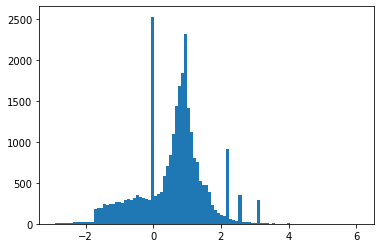

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short use just the first 1000 samples for validation, and the next 10 000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the `.batch` method to create batches of an appropriate size for training. Before batching also remember to `.shuffle` and `.repeat` the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only `layers.Dense` as a baseline, then create larger versions, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

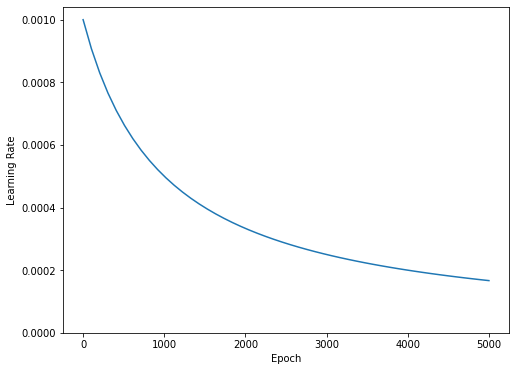

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481


Trainable params: 481


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4961,  binary_crossentropy:0.7294,  loss:0.7294,  val_accuracy:0.4840,  val_binary_crossentropy:0.7200,  val_loss:0.7200,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.5931,  binary_crossentropy:0.6279,  loss:0.6279,  val_accuracy:0.5860,  val_binary_crossentropy:0.6288,  val_loss:0.6288,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6157,  binary_crossentropy:0.6178,  loss:0.6178,  val_accuracy:0.6200,  val_binary_crossentropy:0.6134,  val_loss:0.6134,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6370,  binary_crossentropy:0.6086,  loss:0.6086,  val_accuracy:0.6220,  val_binary_crossentropy:0.6055,  val_loss:0.6055,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6522,  binary_crossentropy:0.6008,  loss:0.6008,  val_accuracy:0.6260,  val_binary_crossentropy:0.5997,  val_loss:0.5997,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6513,  binary_crossentropy:0.5946,  loss:0.5946,  val_accuracy:0.6480,  val_binary_crossentropy:0.5911,  val_loss:0.5911,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6636,  binary_crossentropy:0.5894,  loss:0.5894,  val_accuracy:0.6390,  val_binary_crossentropy:0.5898,  val_loss:0.5898,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6696,  binary_crossentropy:0.5852,  loss:0.5852,  val_accuracy:0.6530,  val_binary_crossentropy:0.5870,  val_loss:0.5870,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6706,  binary_crossentropy:0.5824,  loss:0.5824,  val_accuracy:0.6590,  val_binary_crossentropy:0.5850,  val_loss:0.5850,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6709,  binary_crossentropy:0.5796,  loss:0.5796,  val_accuracy:0.6680,  val_binary_crossentropy:0.5831,  val_loss:0.5831,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1000, accuracy:0.6780,  binary_crossentropy:0.5769,  loss:0.5769,  val_accuracy:0.6530,  val_binary_crossentropy:0.5851,  val_loss:0.5851,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1100, accuracy:0.6735,  binary_crossentropy:0.5752,  loss:0.5752,  val_accuracy:0.6620,  val_binary_crossentropy:0.5807,  val_loss:0.5807,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1200, accuracy:0.6759,  binary_crossentropy:0.5729,  loss:0.5729,  val_accuracy:0.6620,  val_binary_crossentropy:0.5792,  val_loss:0.5792,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1300, accuracy:0.6849,  binary_crossentropy:0.5716,  loss:0.5716,  val_accuracy:0.6450,  val_binary_crossentropy:0.5859,  val_loss:0.5859,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1400, accuracy:0.6790,  binary_crossentropy:0.5695,  loss:0.5695,  val_accuracy:0.6700,  val_binary_crossentropy:0.5776,  val_loss:0.5776,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1500, accuracy:0.6824,  binary_crossentropy:0.5681,  loss:0.5681,  val_accuracy:0.6730,  val_binary_crossentropy:0.5761,  val_loss:0.5761,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1600, accuracy:0.6828,  binary_crossentropy:0.5669,  loss:0.5669,  val_accuracy:0.6690,  val_binary_crossentropy:0.5766,  val_loss:0.5766,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1700, accuracy:0.6874,  binary_crossentropy:0.5657,  loss:0.5657,  val_accuracy:0.6600,  val_binary_crossentropy:0.5774,  val_loss:0.5774,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1800, accuracy:0.6845,  binary_crossentropy:0.5655,  loss:0.5655,  val_accuracy:0.6780,  val_binary_crossentropy:0.5752,  val_loss:0.5752,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1900, accuracy:0.6837,  binary_crossentropy:0.5644,  loss:0.5644,  val_accuracy:0.6790,  val_binary_crossentropy:0.5753,  val_loss:0.5753,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 2000, accuracy:0.6853,  binary_crossentropy:0.5632,  loss:0.5632,  val_accuracy:0.6780,  val_binary_crossentropy:0.5753,  val_loss:0.5753,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 2100, accuracy:0.6871,  binary_crossentropy:0.5625,  loss:0.5625,  val_accuracy:0.6670,  val_binary_crossentropy:0.5769,  val_loss:0.5769,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Now check how the model did:

(0.5, 0.7)

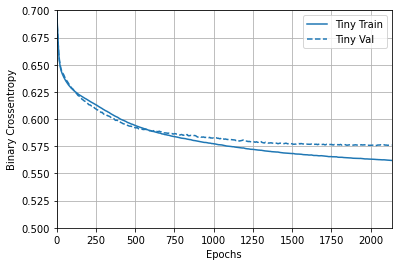

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To see if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753


Trainable params: 753


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4864,  binary_crossentropy:0.7769,  loss:0.7769,  val_accuracy:0.4930,  val_binary_crossentropy:0.7211,  val_loss:0.7211,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6386,  binary_crossentropy:0.6052,  loss:0.6052,  val_accuracy:0.6020,  val_binary_crossentropy:0.6177,  val_loss:0.6177,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6697,  binary_crossentropy:0.5829,  loss:0.5829,  val_accuracy:0.6310,  val_binary_crossentropy:0.6018,  val_loss:0.6018,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6838,  binary_crossentropy:0.5721,  loss:0.5721,  val_accuracy:0.6490,  val_binary_crossentropy:0.5940,  val_loss:0.5940,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6911,  binary_crossentropy:0.5656,  loss:0.5656,  val_accuracy:0.6430,  val_binary_crossentropy:0.5985,  val_loss:0.5985,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6930,  binary_crossentropy:0.5607,  loss:0.5607,  val_accuracy:0.6430,  val_binary_crossentropy:0.6028,  val_loss:0.6028,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Medium model

Now try 3 hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10,241


Trainable params: 10,241


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5017,  binary_crossentropy:0.6840,  loss:0.6840,  val_accuracy:0.4790,  val_binary_crossentropy:0.6723,  val_loss:0.6723,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, 

accuracy:0.7173,  binary_crossentropy:0.5221,  loss:0.5221,  val_accuracy:0.6470,  val_binary_crossentropy:0.6111,  val_loss:0.6111,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7884,  binary_crossentropy:0.4270,  loss:0.4270,  val_accuracy:0.6390,  val_binary_crossentropy:0.7045,  val_loss:0.7045,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Large model

As an exercise, you can create an even larger model, and see how quickly it begins overfitting.  Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5145,  binary_crossentropy:0.7740,  loss:0.7740,  val_accuracy:0.4980,  val_binary_crossentropy:0.6793,  val_loss:0.6793,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0020,  loss:0.0020,  val_accuracy:0.6600,  val_binary_crossentropy:1.8540,  val_loss:1.8540,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6560,  val_binary_crossentropy:2.5293,  val_loss:2.5293,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

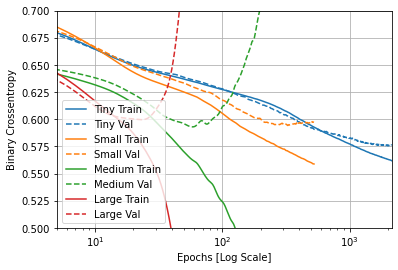

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpn1rdh98q/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights-one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5126,  binary_crossentropy:0.7481,  loss:2.2415,  val_accuracy:0.4950,  val_binary_crossentropy:0.6707,  val_loss:2.0653,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6625,  binary_crossentropy:0.5945,  loss:0.6173,  val_accuracy:0.6400,  val_binary_crossentropy:0.5871,  val_loss:0.6100,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6690,  binary_crossentropy:0.5864,  loss:0.6079,  val_accuracy:0.6650,  val_binary_crossentropy:0.5856,  val_loss:0.6076,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6790,  binary_crossentropy:0.5762,  loss:0.5976,  val_accuracy:0.6550,  val_binary_crossentropy:0.5881,  val_loss:0.6095,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6843,  binary_crossentropy:0.5697,  loss:0.5920,  val_accuracy:0.6650,  val_binary_crossentropy:0.5878,  val_loss:0.6101,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6897,  binary_crossentropy:0.5651,  loss:0.5907,  val_accuracy:0.6890,  val_binary_crossentropy:0.5798,  val_loss:0.6055,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6945,  binary_crossentropy:0.5610,  loss:0.5864,  val_accuracy:0.6820,  val_binary_crossentropy:0.5772,  val_loss:0.6026,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

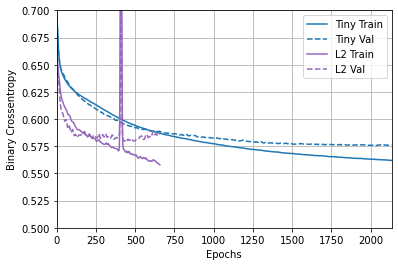

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As you can see, the `"L2"` regularized model is now much more competitive with the the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization.

**First:** if you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

**Second:** This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "Decoupled Weight Decay" is seen in optimizers like `optimizers.FTRL` and `optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5,
1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4961,  binary_crossentropy:0.8110,  loss:0.8110,  val_accuracy:0.5330,  val_binary_crossentropy:0.6900,  val_loss:0.6900,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6557,  binary_crossentropy:0.5961,  loss:0.5961,  val_accuracy:0.6710,  val_binary_crossentropy:0.5788,  val_loss:0.5788,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6871,  binary_crossentropy:0.5622,  loss:0.5622,  val_accuracy:0.6860,  val_binary_crossentropy:0.5856,  val_loss:0.5856,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7246,  binary_crossentropy:0.5121,  loss:0.5121,  val_accuracy:0.6820,  val_binary_crossentropy:0.5927,  val_loss:0.5927,  
.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

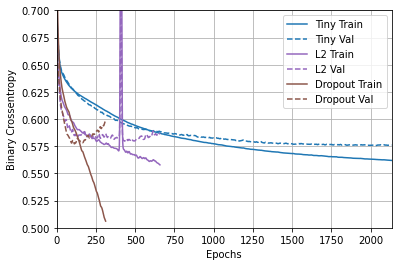

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5090,  binary_crossentropy:0.8064,  loss:0.9648,  val_accuracy:0.4660,  val_binary_crossentropy:0.6877,  val_loss:0.8454,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6445,  binary_crossentropy:0.6050,  loss:0.6350,  val_accuracy:0.6630,  val_binary_crossentropy:0.5871,  val_loss:0.6169,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6660,  binary_crossentropy:0.5932,  loss:0.6186,  val_accuracy:0.6880,  val_binary_crossentropy:0.5722,  val_loss:0.5975,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6697,  binary_crossentropy:0.5818,  loss:0.6100,  val_accuracy:0.6900,  val_binary_crossentropy:0.5614,  val_loss:0.5895,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6749,  binary_crossentropy:0.5742,  loss:0.6046,  val_accuracy:0.6870,  val_binary_crossentropy:0.5576,  val_loss:0.5881,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6854,  binary_crossentropy:0.5703,  loss:0.6029,  val_accuracy:0.6970,  val_binary_crossentropy:0.5458,  val_loss:0.5784,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6806,  binary_crossentropy:0.5673,  loss:0.6015,  val_accuracy:0.6980,  val_binary_crossentropy:0.5453,  val_loss:0.5795,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6937,  binary_crossentropy:0.5583,  loss:0.5938,  val_accuracy:0.6870,  val_binary_crossentropy:0.5477,  val_loss:0.5832,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6911,  binary_crossentropy:0.5576,  loss:0.5947,  val_accuracy:0.7000,  val_binary_crossentropy:0.5446,  val_loss:0.5817,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

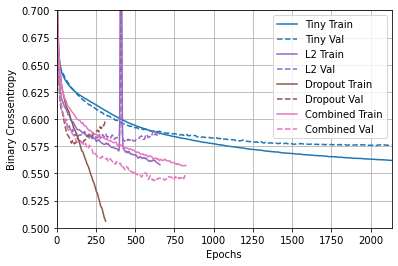

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorDoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.